# Simulating the effect of pixelization errors on Gaussian fittings

## Importing packages

In [376]:
import os
import sys
sys.path.append('./')

import math
import numpy as np
from numpy import size
from scipy.optimize import curve_fit
from astropy.table import Table, Column
from astropy.io import fits
from spectral_cube import SpectralCube
import astropy.units as u


import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt
%matplotlib inline

## Defining functions and classes

In [377]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [378]:
# parent class
class spectrum:
    'Parent class for a spectrum \n \
     Attributes \n \
     num_components ( int ) : counters for total number of spectra \n \
    '
    num_components = 0
    
    def __init__(self):
        spectrum.num_components += 1
    
    def __del__(self):
        spectrum.num_components -= 1
    

    
# subclasses
class gaussian_spectrum( spectrum ):
    'Sub-class of spectrum. Gaussian profile \n \
     constructed by, e.g., spectrum1 = gaussian_spectrum() \n\n \
     Attributes: \n \
     A (float) : Amplitude of the gaussian spectrum \n \
     sigma (float) : standard deviation [bins] of the gaussian spectrum \n \
     bins (int) : number of bins to sample the spectrum. \n \
     data (numpy array) : the stored intensity values \n \
     resampleddata (numpy array) : the stored, resampled intensity values \n \
     '

    num_components = 0

    def __init__(self, name = 'gaussian_unknown', 
               A=1.0, sigma=1.0, bins=256):
        spectrum.num_components += 1
        gaussian_spectrum.num_components += 1
        self.name  = name
        self.A = A
        self.sigma = sigma
        self.bins  = bins
        self.x     = np.arange(0, bins)
        self.center = float(bins - 1) / 2.0

        self.data = \
        A * np.exp( - ( self.x - self.center)**2.0 / (2.0 * sigma**2) )
        self.resampleddata = self.data
    # print( self.name )
    # print( self.data )
    
    def __del__(self):
        spectrum.num_components -= 1
        gaussian_spectrum.num_components -= 1
    
    def getprofile(self):
        profile   = self.A * np.exp( - ( self.x - self.center)**2.0 / (2.0 * self.sigma**2) )    
        self.data = profile

    def resample(self, pixelsize=20, pixelshift=10):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum
    
        for i in range(0, pixelshift):
            self.resampleddata[i] = np.sum( self.data[0:pixelshift] ) / pixelsize

        resampled_bins = int( 
            ( self.bins - pixelshift ) / pixelsize
        )
        for i in range(0, resampled_bins):
            for j  in range(0, pixelsize):
                k = pixelshift + pixelsize * i + j
                start = pixelshift + pixelsize * i
                end   = pixelshift + pixelsize * (i+1)
                self.resampleddata[k] = np.sum( self.data[start:end] ) / pixelsize
        
    def add_noise(self, RMS=0.1):
    # RMS: the RMS noise level
        noise = np.random.normal(0.0, RMS, self.bins)
        self.data = self.data + noise
    
    def refit_gaussian(self):
        p0 = [1., self.bins/2.0, 1.]
        coeff, var_matrix = curve_fit(gauss, self.x, self.resampleddata, p0=p0, maxfev=500000)
        return coeff

class gaussian_spectrum_split( gaussian_spectrum ):
    'Sub-class of spectrum. Gaussian profile \n \
     constructed by, e.g., spectrum1 = gaussian_spectrum_split() \n\n \
      \n \
    '
  # inherent from parent classes
    def _init_(self, name = 'gaussian_unknown', 
               A=1.0, sigma=1.0, bins=256):
        super(gaussian_spectrum_split, self)._init_(name=name, A=A, sigma=sigma, bins=bins)

    def __del(self):
        super().__del__()
    
    def _resample(self, pixelsize=20, pixelshift=10):
        super(gaussian_spectrum_split, self).resample(pixelsize=pixelsize, pixelshift=pixelshift)
    
    def _add_noise(self, RMS=0.1):
        super(gaussian_spectrum_split, self).add_noise(RMS=RMS)
    
    def _refit_gaussian(self):
        return  super(gaussian_spectrum_split, self).refit_gaussian()
   
    
  # New methods for this subclass
    def loadstrength(self, lsfile):
        self.strengthtable = np.loadtxt(lsfile, comments='#',
                                        dtype={'names': ('transition_name', 'freq_Hz', 'line_strength'),
                                               'formats': ('<U300', 'f', 'f')}
                                       )
        self.central_freqHz = 0.0
        self.intensity_normalization = np.zeros( size(self.strengthtable) )
        self.offset_freqHz           = np.zeros( size(self.strengthtable) )
        self.numsplits =  size(self.strengthtable)
        total_strength = 0.0
    
        for i in range( 0, self.numsplits ):
            self.central_freqHz += self.strengthtable[i][1] * self.strengthtable[i][2]
            total_strength += self.strengthtable[i][2]
        self.central_freqHz = self.central_freqHz / total_strength
    
        for i in range( 0, self.numsplits ):
            self.intensity_normalization[i] = self.strengthtable[i][2] / total_strength
            self.offset_freqHz[i] = self.strengthtable[i][1] - self.central_freqHz
    

    def getflux(self, pixelsize_Hz=10000.0):
        self.data *= 0.0
    
        for i in range( 0, self.numsplits ):
            temp = gaussian_spectrum(
                name = 'Baobab',
                A    = self.intensity_normalization[i] * self.A,
                sigma = self.sigma,
                bins  = self.bins
                                    )
            temp.center = temp.center + self.offset_freqHz[i] / pixelsize_Hz
            temp.getprofile()
            self.data += temp.data
    
        self.resampleddata = self.data

def resampleobs(sp, bins):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum

    #spdata = np.array( range( bins ) )
    #print spdata
    numbins = int( bins *1.0 / len(sp) )
    spdata = []
    j = 0
    i = 0
    for j in range( len(sp) ):
        for k in range(0, numbins):
            if i < bins:
                #print 'sp[j]={}'.format( sp[j] )
                spdata = np.append( spdata, sp[j] )
                #print 'i={}, k={}, j={}'.format( i, k, j )
                #print 'spdata[i] = {}'.format( spdata[i] )
                i += 1
    #print len(spdata)
    max_index = int( (np.max( ( np.where( spdata == np.nanmax(spdata) )[0] ) ) - \
                        len(np.where( spdata == np.nanmax(spdata) )[0])/2.0))
    
    delta_index = max_index - bins/2
    #print delta_index, max_index
    fvpix   = (25.357/1920) * delta_index - 17.6921  # the velocity of first pixel in km/s
    #print fvpix
    spdata1 = []
    j = delta_index - 1
    for i in range( (len(spdata) - delta_index) ):
        spdata1 = np.append( spdata1, spdata[j] )
        #print 'spdata[j] = {}'.format(spdata[j])
        j += 1
        #print j , i
    return spdata1, fvpix

print "Done ~ ^_^ ~"

Done ~ ^_^ ~


## Printing help files

In [36]:
print ( 'spectrum :\n', spectrum.__doc__ )
print ( 'gaussian_spectrum :\n', gaussian_spectrum.__doc__ )

spectrum :
 Parent class for a spectrum 
      Attributes 
      num_components ( int ) : counters for total number of spectra 
   
gaussian_spectrum :
 Sub-class of spectrum. Gaussian profile 
      constructed by, e.g., spectrum1 = gaussian_spectrum() 

    Attributes: 
    A (float) : Amplitude of the gaussian spectrum 
    sigma (float) : standard deviation [bins] of the gaussian spectrum 
    bins (int) : number of bins to sample the spectrum. 
    data (numpy array) : the stored intensity values 
    resampleddata (numpy array) : the stored, resampled intensity values 
   


## Plotting results

In [124]:
'''
subcube0 = SpectralCube.read(f3)
subcube0.allow_huge_operations=True
subcube0 = subcube0.with_spectral_unit(unit=u.km/u.s, velocity_convention='radio')
Tpeakmap = subcube0.spectral_slab(-10*u.km/u.s, 5.5*u.km/u.s).max(axis=0)
rmsmap = subcube0.spectral_slab(-17*u.km/u.s, -13*u.km/u.s).std(axis=0)
#peaksnr = Tpeakmap/rmsmap
Tpeakmap.write('Tpeak_NH2D.fits', format='fits', overwrite=True)
rmsmap.write('rmsmap_NH2D.fits', format='fits', overwrite=True)
'''

In [379]:
Target = '../ANALYSIS/imfit_finial_results_addradec_sortflux_table_pbflux_mass_Mach_seperatemass_area_NH2D.fits'
T = Table.read(Target, hdu=3)
Mgas = T['Mass']          # gas mass
Dreff = T['decr_eff']     # beam-deconvolved effective radius in arcsec
Asig = T['fitted_Asigma']   # (NH2D) non-thermal + sound speed
T[43]
#T.show_in_browser()


path1 = '../LINE_FITTING/NH2D/'
f1    = path1 + 'nh2d_snr5_multi_results_oct06_allcomps.fits'

path2 = '../ANALYSIS/DENDRO/'
f2    = path2 + 'imfit_densecore_id_multiD.fits'

path3 = '../Feb23_Delivery/NH2D/'
f3    = path3 + 'IRDC_G350_NH2D_JUNE23_mom0mask_niters1e4_thresh12_multi072142.image.fits'

path4 = '../LINE_FITTING/NH2D/'
f4    = path4 + 'map_compidex_nh2d.fits'

f5    = 'Tpeak_NH2D.fits'
f6    = 'rmsmap_NH2D.fits'

hdu1 = fits.open(f1)
hdu2 = fits.open(f2)
hdu3 = fits.open(f3)
hdu4 = fits.open(f4)
hdu5 = fits.open(f5)
hdu6 = fits.open(f6)

data1 = hdu1[0].data
data2 = hdu2[0].data
data3 = hdu3[0].data
hdr3  = hdu4[0].header
data4 = hdu4[0].data

data5 = hdu5[0].data
data6 = hdu6[0].data
print data1.shape, data2.shape



G       = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.213      # km/s
v_pix   = v_delta / 16.0  # general finner pixel grids for the original spectrum

# Assuming cores are virialized
alpha      = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))
Reff       = Dreff * (1300.0 / 206265.0)         # angular radius --> 
sigma      = np.sqrt(alpha * Mgas * G /(5.* Reff))  # km/s
#'''
peak_intensity = []
peak_sn        = []
spcube         = []
for i in range(size(T)):
#for i in range(5):
    Adata1         = np.where(data2 == i, data5, np.nan)
    Adata1_err     = np.where(data2 == i, data6, np.nan)
    peak_intensity = np.append(peak_intensity, np.nanmean(Adata1))
    peak_sn        = np.append(peak_sn, np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err))
    #print np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err)
    #print i
    cube    = np.where( data2 == i, data3, np.nan )
    HDU     = fits.PrimaryHDU( data=cube, header=hdr3 )
    HDUList = fits.HDUList( [HDU] )
    cube    = SpectralCube.read( HDUList )
    cube.allow_huge_operations=True
    sp      = cube.mean( axis=(1,2) )
    spcube.append( sp.value )
## 29, 33, 38, 40, 43, 45, 46, 47, 48  without sigma information
# 32, 41, without beam-deconvolved radius

core_index = []
for i in range(size(T)):
    mapidex = np.where(data2 == i, data4, np.nan)
    if np.nanmax(mapidex) > 1:
        core_index.append(i)

print v_pix
v_pix_Hz = 8.593133089470E+10 * v_pix/(3e5)
print 'v_pix_Hz (Hz)=', v_pix_Hz

print "Done ~ ^_^ ~"

(4, 1536, 1024) (1536, 1024)


/home/sli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in divide


0.0133125
v_pix_Hz (Hz)= 3813.20280845
Done ~ ^_^ ~


/home/sli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: All-NaN slice encountered


In [402]:
'''
print 120*16

lsfile = 'nh2d_linestrength.txt'

strengthtable = np.loadtxt(lsfile, comments='#',
                           dtype={'names': ('transition_name', 'freq_Hz', 'line_strength'),
                                  'formats': ('<U300', 'f', 'f')}
                          )
central_freqHz = 0.0
intensity_normalization = np.zeros( size(strengthtable) )
offset_freqHz           = np.zeros( size(strengthtable) )
numsplits =  size(strengthtable)
total_strength = 0.0
    
for i in range( 0, numsplits ):
    central_freqHz += strengthtable[i][1] * strengthtable[i][2]
    #print strengthtable[i][1],  strengthtable[i][2], strengthtable[i][1] * strengthtable[i][2]

    total_strength += strengthtable[i][2]
    central_freqHz = central_freqHz / total_strength
    #print central_freqHz, total_strength
    
for i in range( 0, numsplits ):
    intensity_normalization[i] = strengthtable[i][2] / total_strength

    offset_freqHz[i] = strengthtable[i][1] - central_freqHz
    print intensity_normalization[i], offset_freqHz[i]

#print size(strengthtable), total_strength, central_freqHz, 
#print strengthtable[0][1] * strengthtable[0][2]
print strengthtable
'''

"\nprint 120*16\n\nlsfile = 'nh2d_linestrength.txt'\n\nstrengthtable = np.loadtxt(lsfile, comments='#',\n                           dtype={'names': ('transition_name', 'freq_Hz', 'line_strength'),\n                                  'formats': ('<U300', 'f', 'f')}\n                          )\ncentral_freqHz = 0.0\nintensity_normalization = np.zeros( size(strengthtable) )\noffset_freqHz           = np.zeros( size(strengthtable) )\nnumsplits =  size(strengthtable)\ntotal_strength = 0.0\n    \nfor i in range( 0, numsplits ):\n    central_freqHz += strengthtable[i][1] * strengthtable[i][2]\n    #print strengthtable[i][1],  strengthtable[i][2], strengthtable[i][1] * strengthtable[i][2]\n\n    total_strength += strengthtable[i][2]\n    central_freqHz = central_freqHz / total_strength\n    #print central_freqHz, total_strength\n    \nfor i in range( 0, numsplits ):\n    intensity_normalization[i] = strengthtable[i][2] / total_strength\n\n    offset_freqHz[i] = strengthtable[i][1] - central_fr

In [399]:
'''
0.21km/s correspond to 0.00006014869 GHz at frequency 85.92627GHz
freq_dict:
    'o-1_01-1_11_12': 85.926186e9,
    'o-1_01-1_11_13': 85.926191e9,
    'o-1_01-1_11_14': 85.926212e9, 0.000058
    'o-1_01-1_11_15': 85.926225e9, 0.000045
    'o-1_01-1_11_16': 85.926243e9, 0.000037
    'o-1_01-1_11_17': 85.926244e9, 0.000036
        
    'o-1_01-1_11_18': 85.926270e9, 0
    'o-1_01-1_11_19': 85.926282e9, 0.000012
    'o-1_01-1_11_20': 85.926284e9, 0.000014
    'o-1_01-1_11_21': 85.926288e9, 0.000018
        
    'o-1_01-1_11_22': 85.926301e9, 0.000029
    'o-1_01-1_11_23': 85.926314e9, 0.000034
    'o-1_01-1_11_24': 85.926323e9, 0.000053
    'o-1_01-1_11_25': 85.926333e9,
        

line_strength_dict:        
    'o-1_01-1_11_12': 0.09296,
    'o-1_01-1_11_13': 0.00000,
    'o-1_01-1_11_14': 0.02677,
    'o-1_01-1_11_15': 0.02341,
    'o-1_01-1_11_16': 0.00798,
    'o-1_01-1_11_17': 0.01984,
        
    'o-1_01-1_11_18': 0.17288,
    'o-1_01-1_11_19': 0.03609,
    'o-1_01-1_11_20': 0.01423,
    'o-1_01-1_11_21': 0.01265,
        
    'o-1_01-1_11_22': 0.00934,
    'o-1_01-1_11_23': 0.01131,
    'o-1_01-1_11_24': 0.06547,
    'o-1_01-1_11_25': 0.00541,
  
'''
print 0.17288+0.03609+0.01423+0.01265+\
0.00934


0.24519


0.11070240288972855 0.5097952548978099


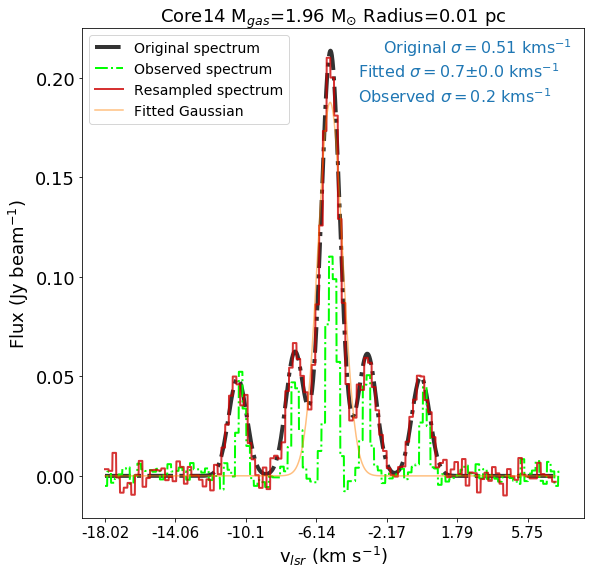

In [403]:

# define line strength file
lsfile = 'nh2d_linestrength.txt'

iterations = 1
linewidth_fits = np.zeros(iterations)

kk = [13]

#for i in range(2):
    #print 'i', i
for i in kk: 
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        #print itr
    # generate spectrum
        test_spectrum = gaussian_spectrum_split(
            name = 'test', 
            A = np.nanmax(spcube[i])/0.24519, 
            sigma = sigma[i]/v_pix, 
            bins = 1920)
        print peak_intensity[i],sigma[i]
       # print 'sigma[i]',sigma[i], 'sigma[i]/v_pix',sigma[i]/v_pix
        test_spectrum.loadstrength('nh2d_linestrength.txt')
        test_spectrum.getflux(pixelsize_Hz=v_pix_Hz)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    )    
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 1920 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=2, 
                     label = 'Observed spectrum'
                    ) 

    
    # inject noise
        noise = np.nanmax(spcube[i]) / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        #plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
            # linewidth=2, label = 'Noisy spectrum'
        #        )
           
    # resampling
        #test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        #print int(v_delta / v_pix)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
                     color = (0.8, 0.0, 0.0, 0.8),
                     linewidth = 2, 
                     label = 'Resampled spectrum'
                    )    
        else:
            pass  

    # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                     label='Fitted Gaussian'
                    )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                         color = (1, 0.5, 0, 0.5),
                        )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
                     'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                    )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                     %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
        
            plt.text( 0.55, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )

    plt.title('Core%s M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( i+1, str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0, 300, 600, 900, 1200, 1500, 1800), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+300*25.357/1920, 2))),
                '%s'%( str( round(fvpix+600*25.357/1920, 2))),
                '%s'%( str( round(fvpix+900*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1200*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1500*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1800*25.357/1920, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)

    #plt.savefig('simulation_split_%s.pdf'%(str(i)), 
    #          transparent = True
    #            )

0.0133125
v_pix_Hz (Hz)= 3813.20280845


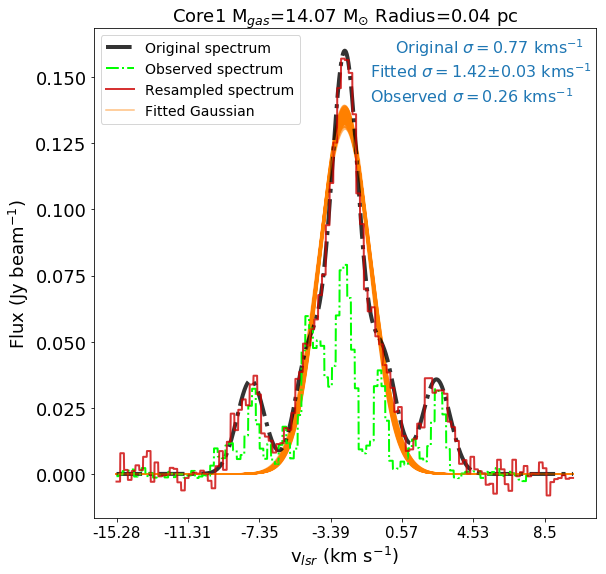

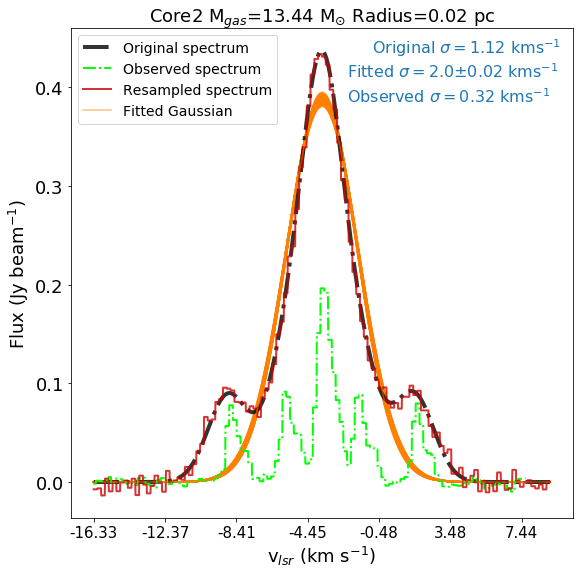

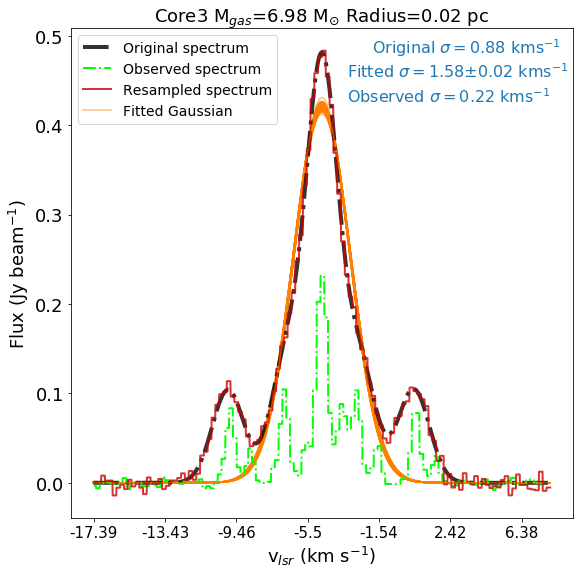

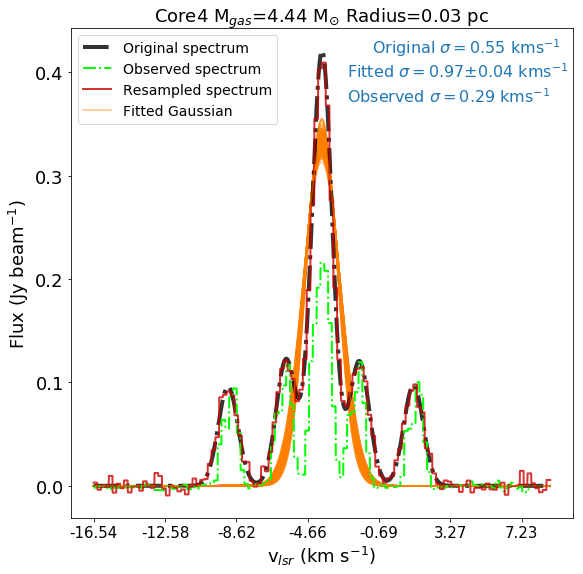

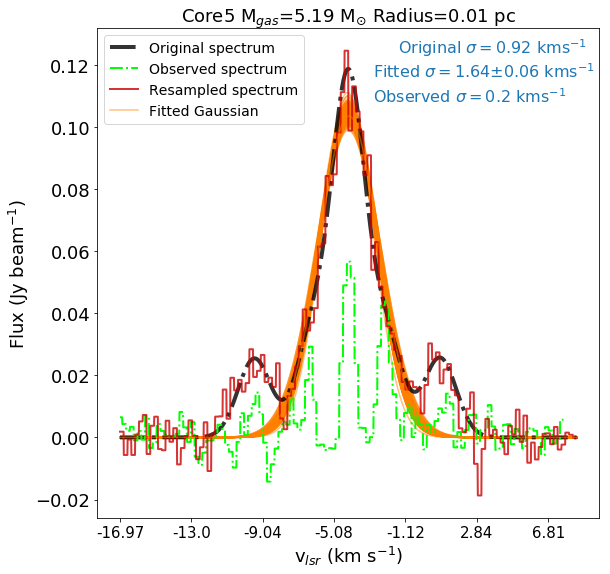

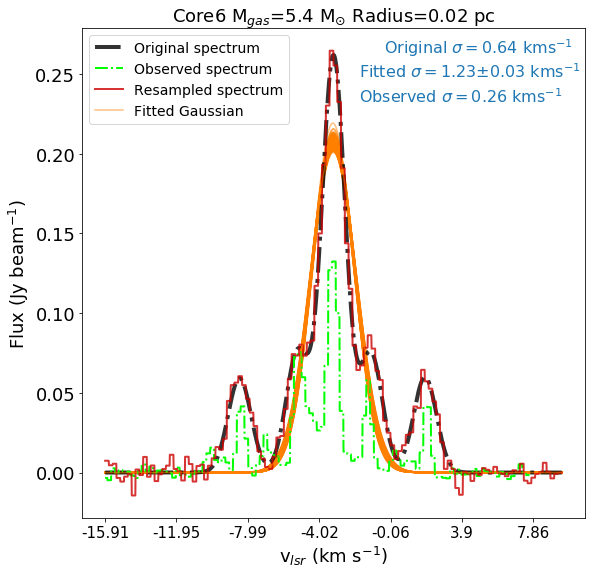

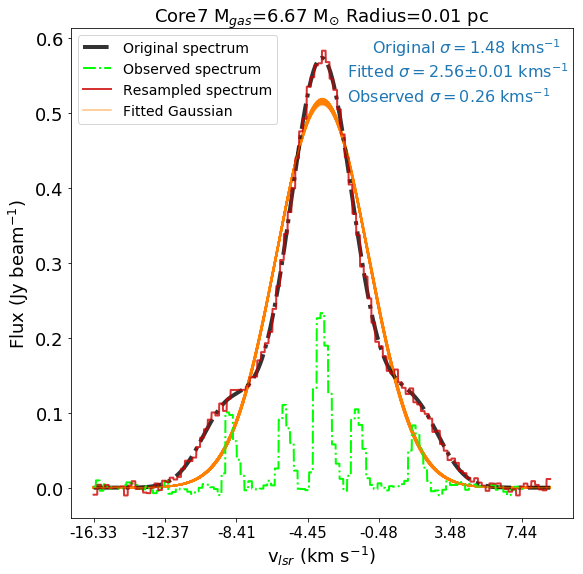

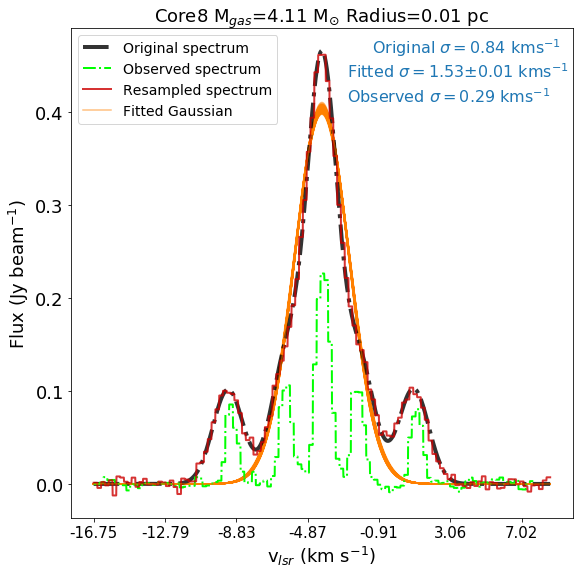

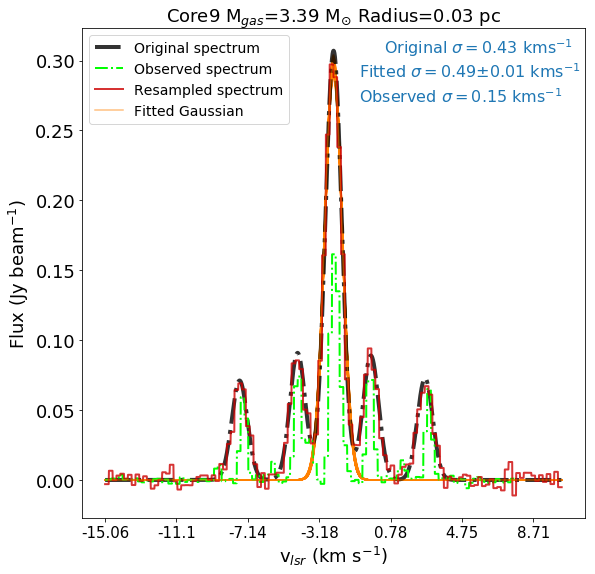

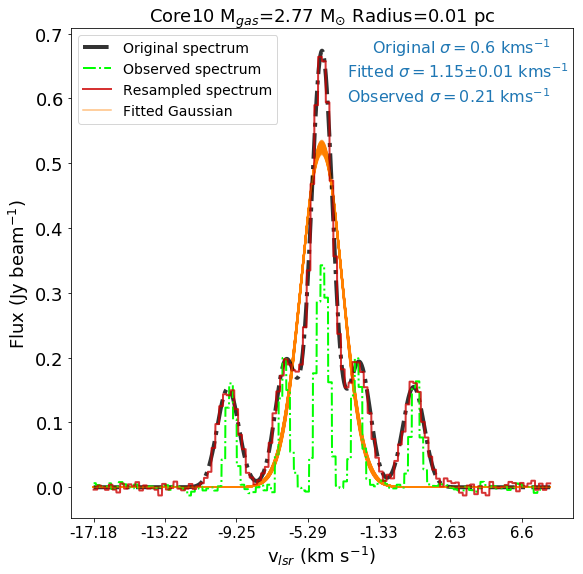

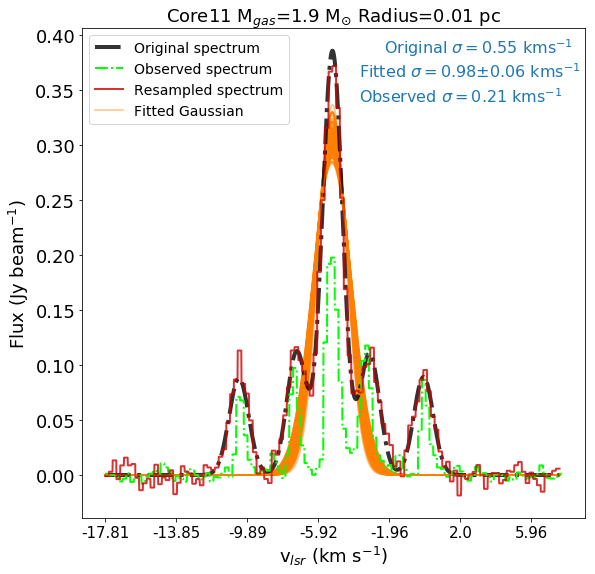

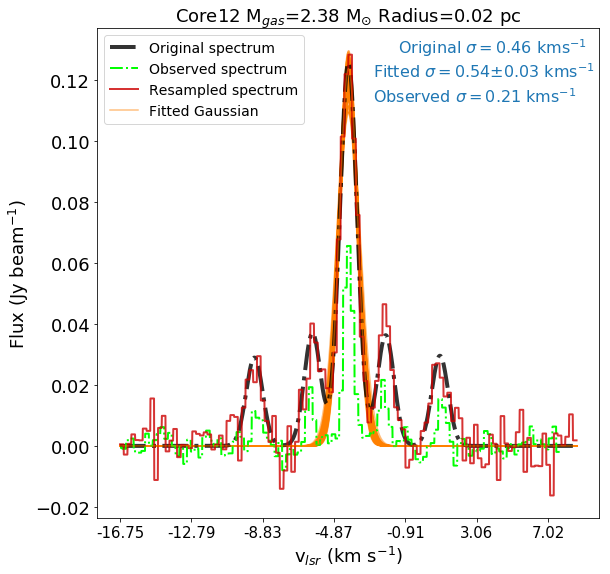

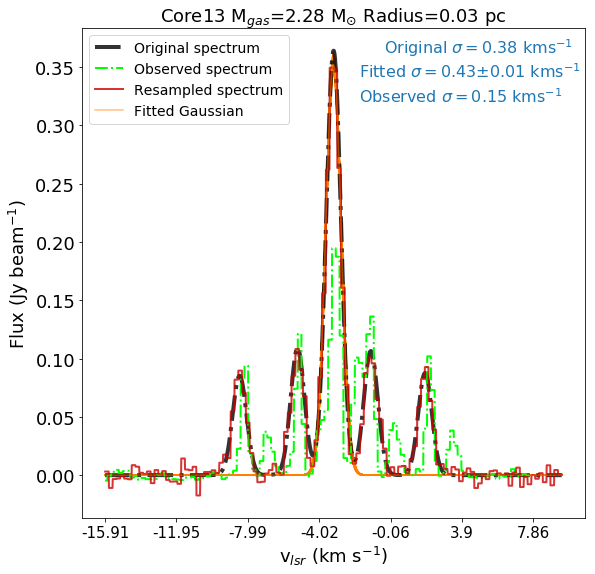

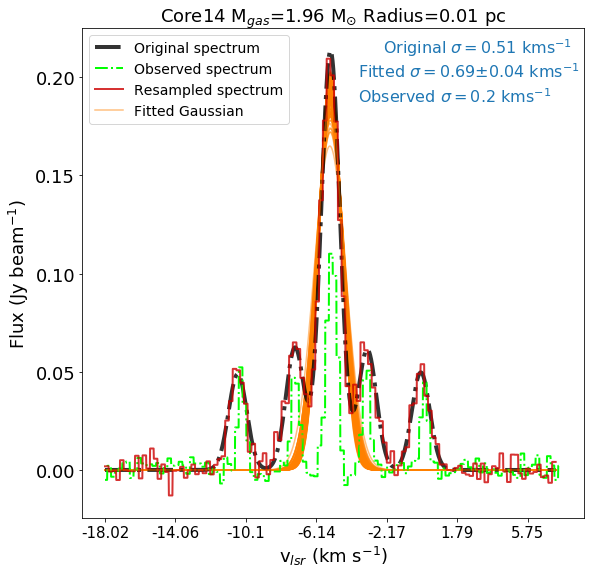

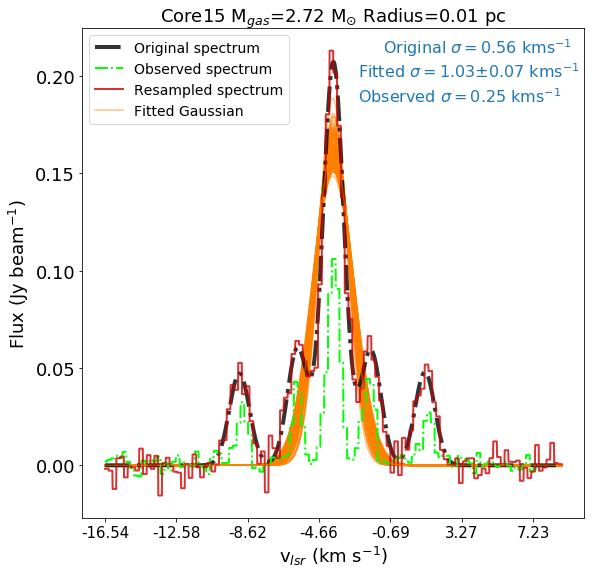

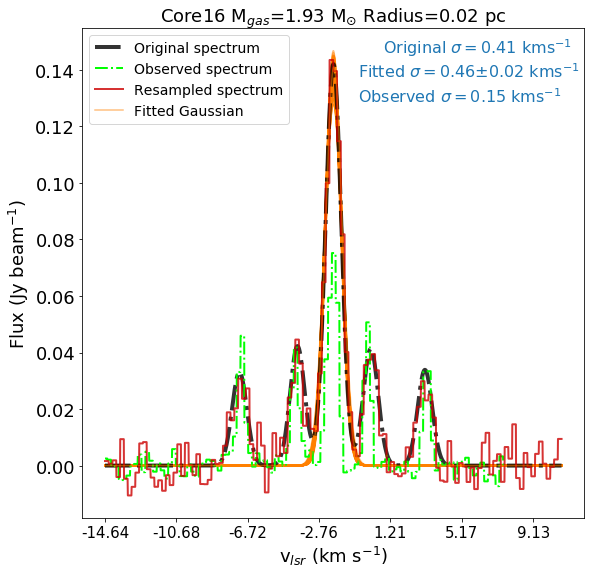

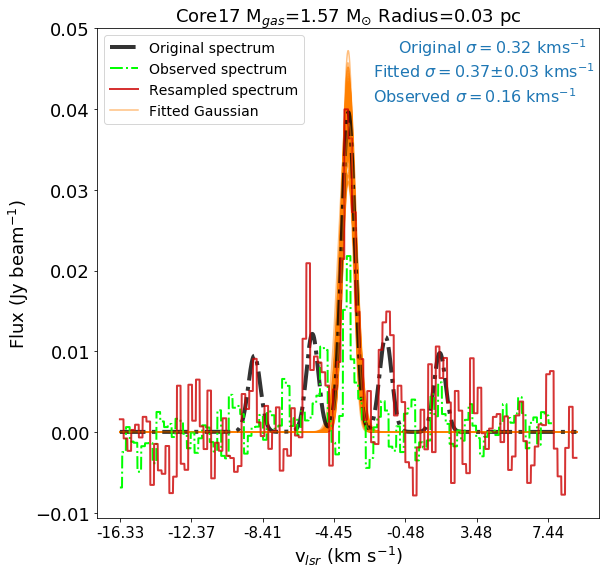

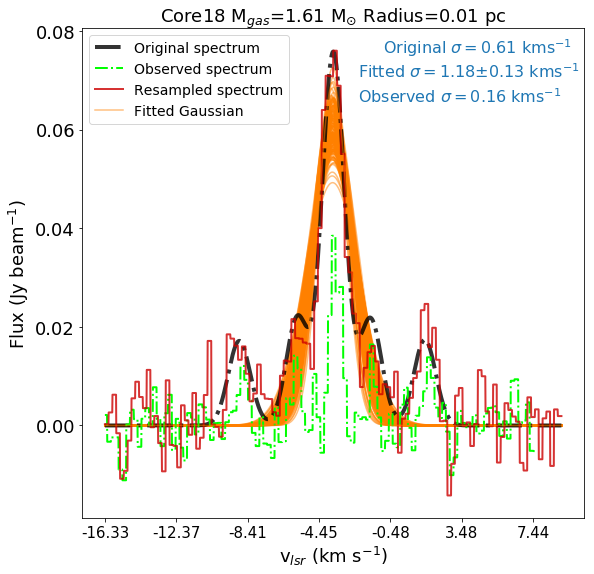

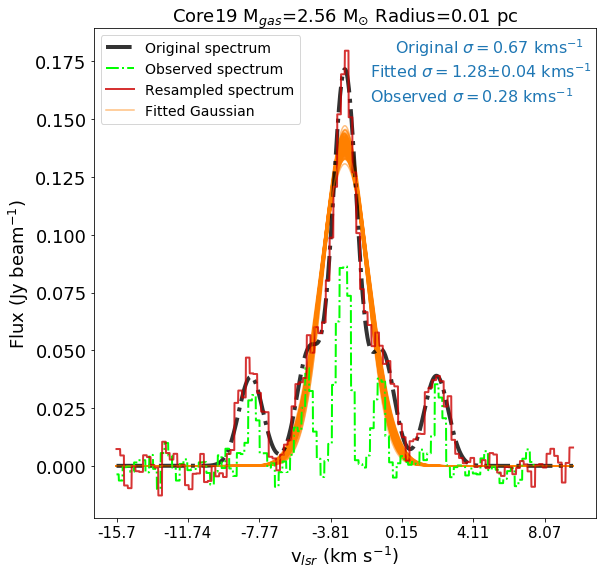

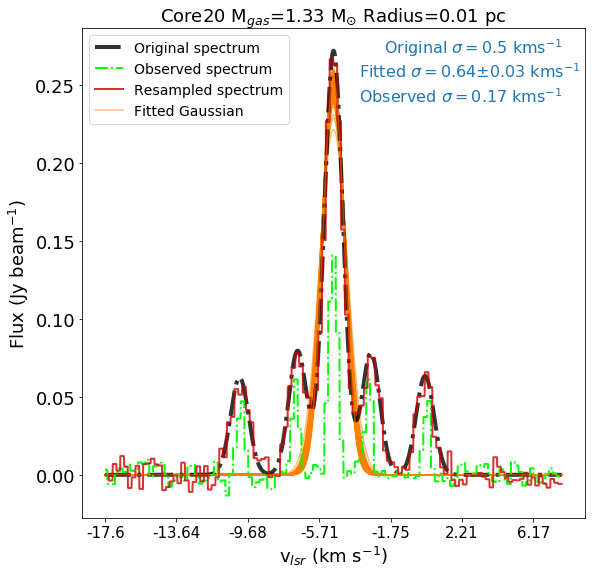

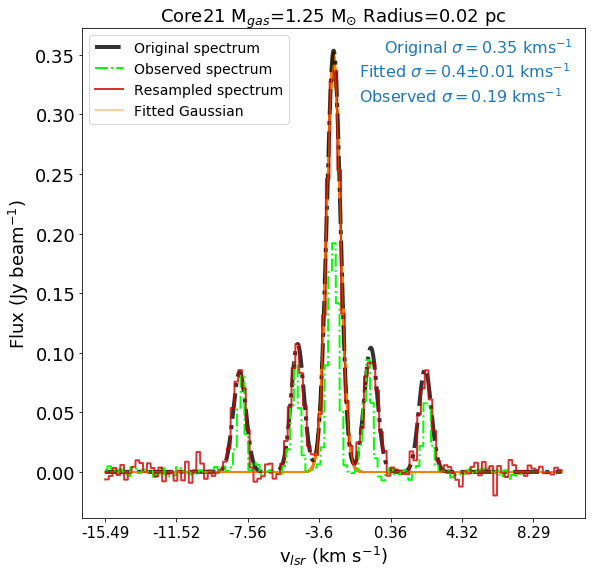

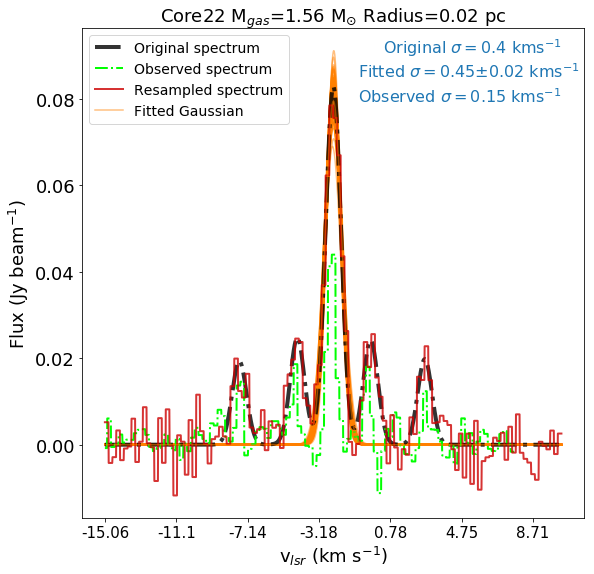

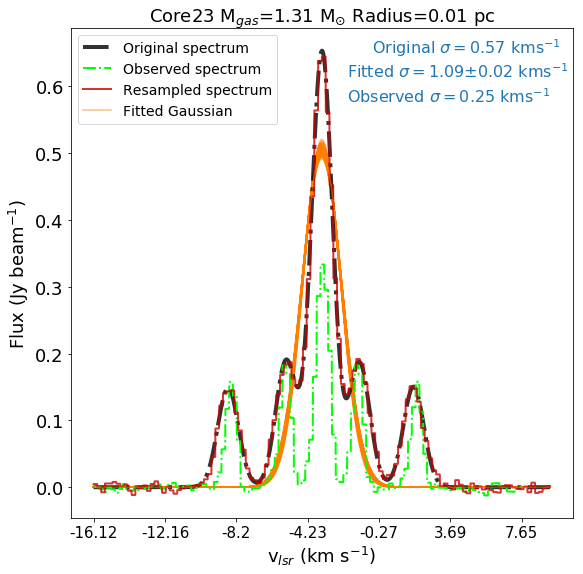

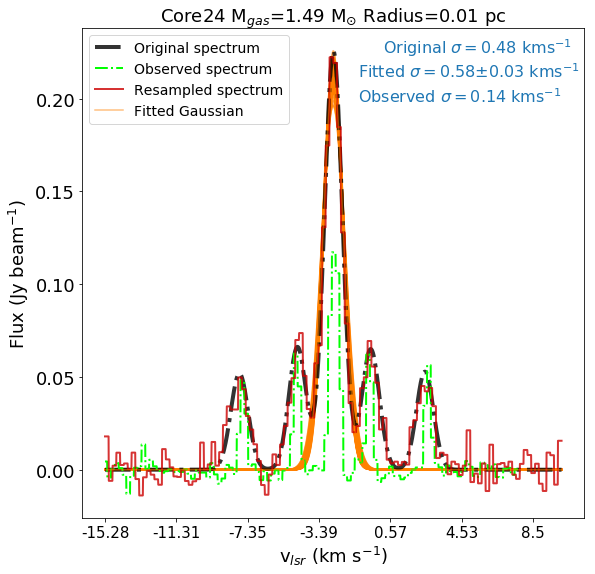

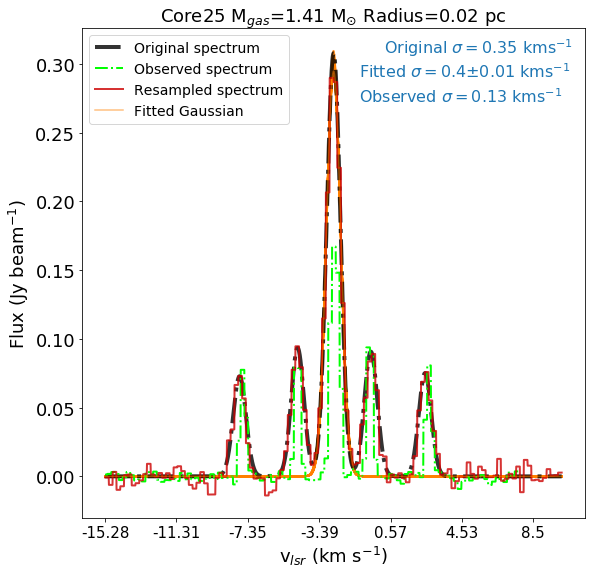

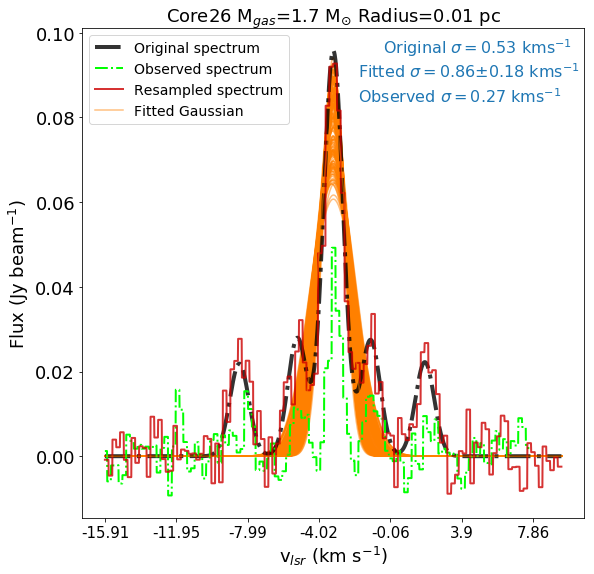

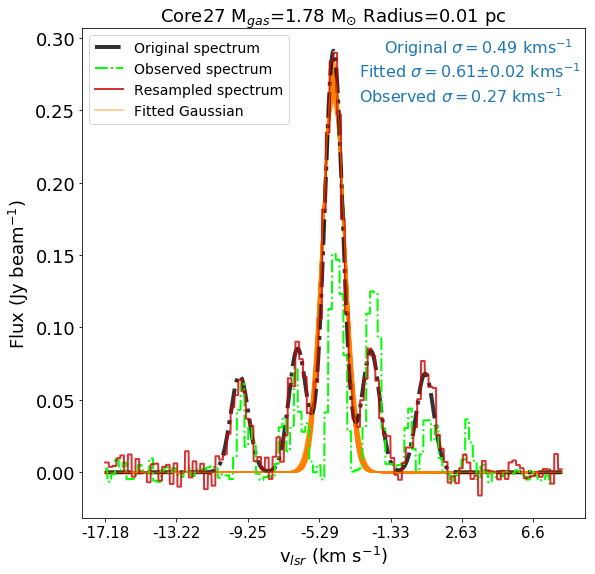

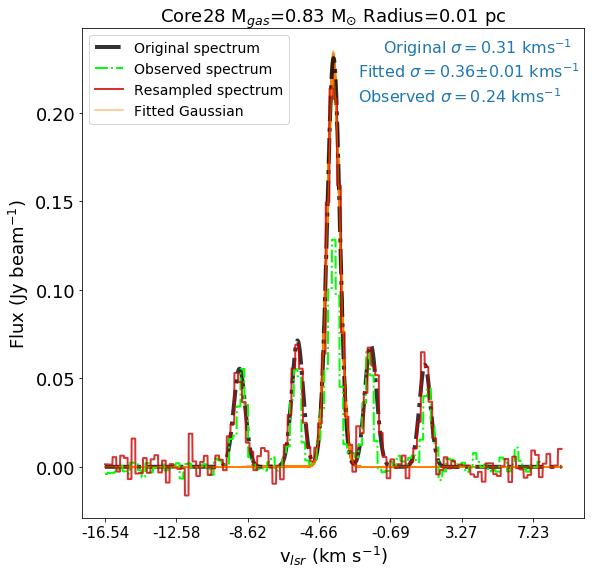

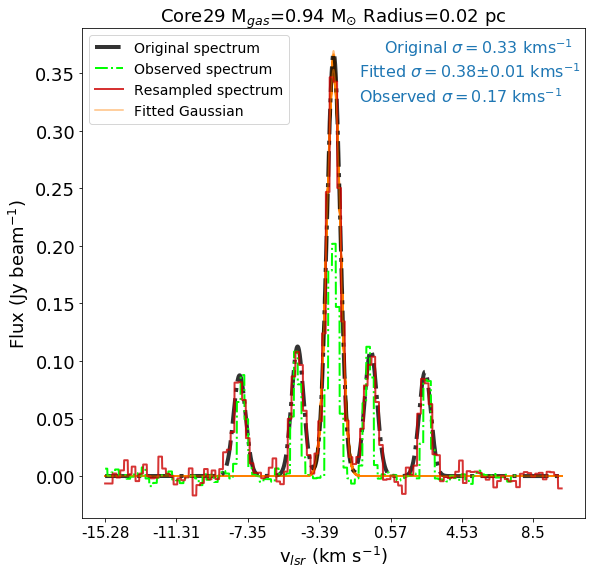

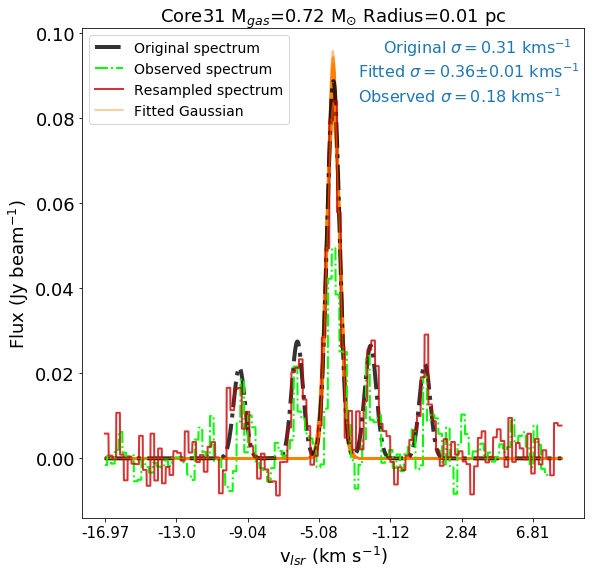

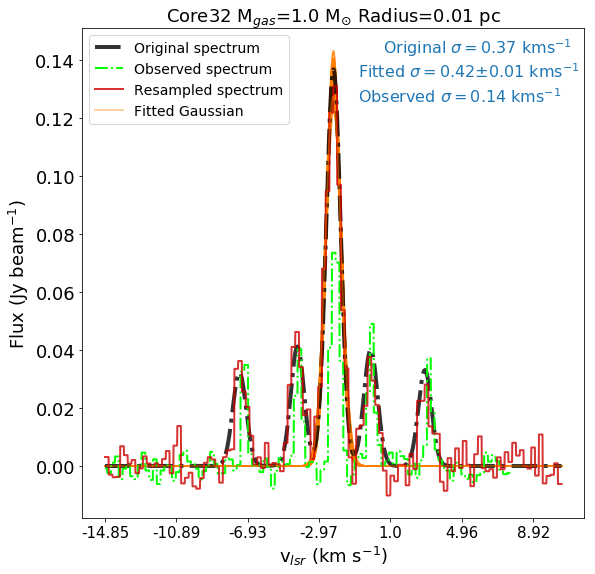

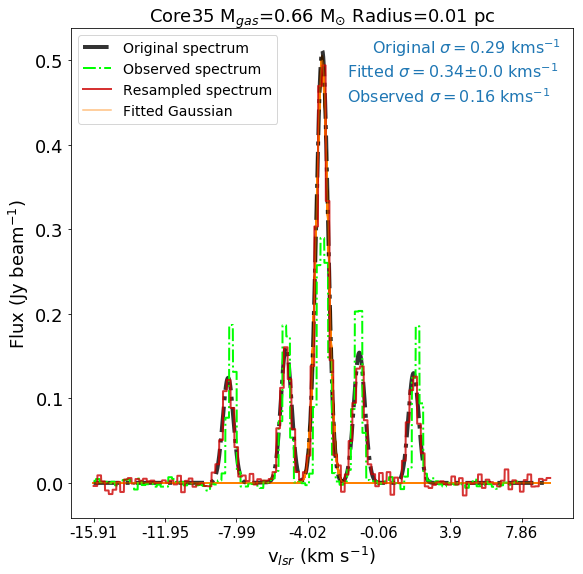

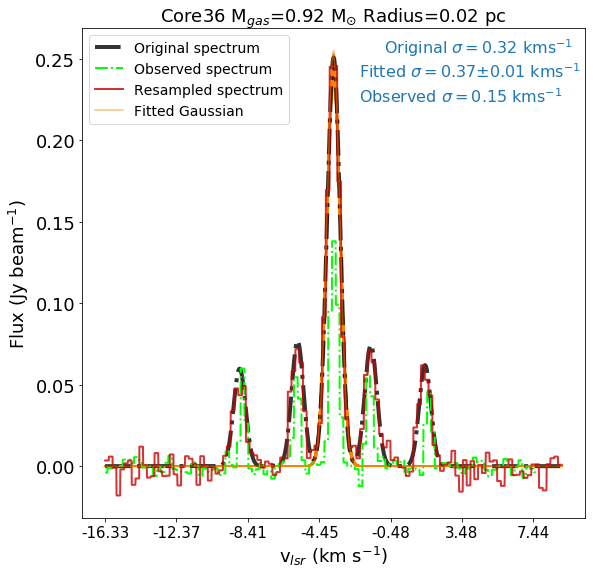

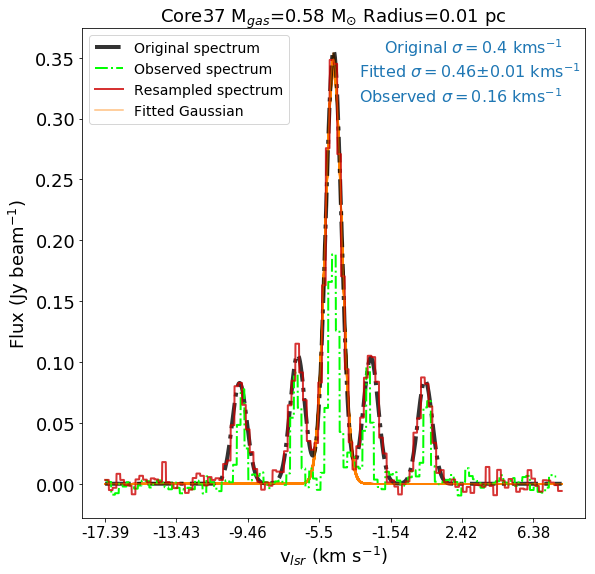

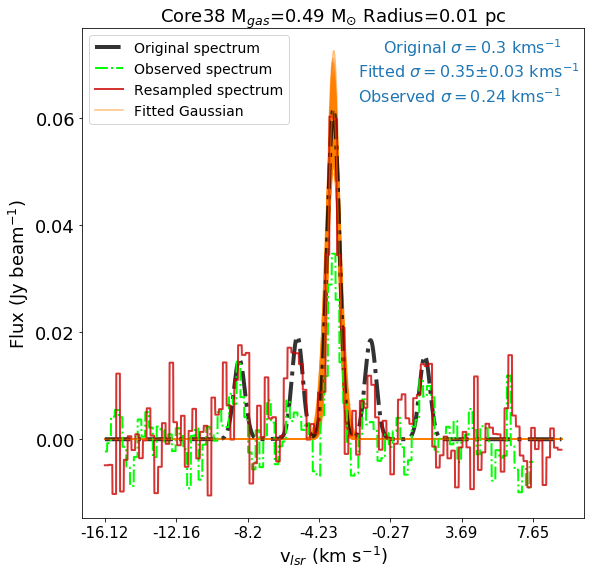

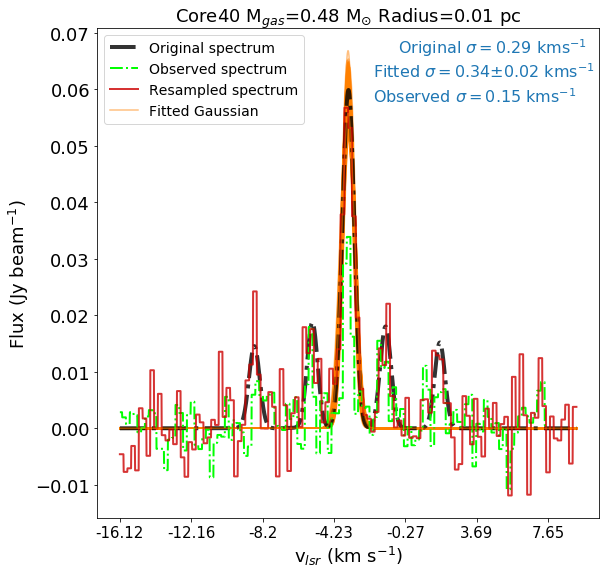

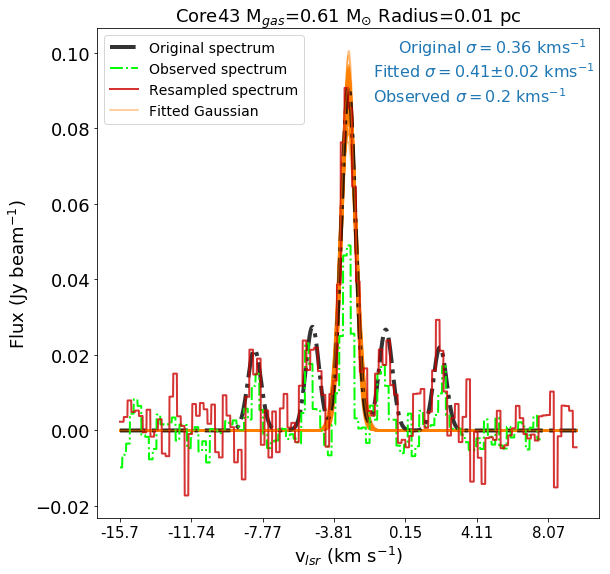

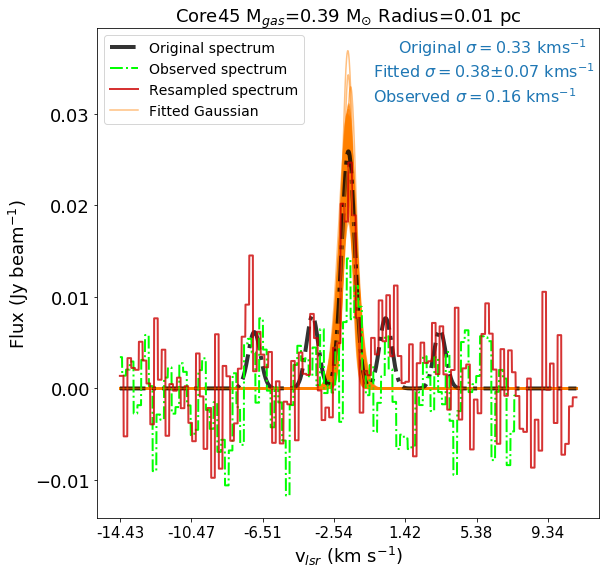

In [401]:
print v_pix
v_pix_Hz = 8.593133089470E+10 * v_pix/(3e5)
print 'v_pix_Hz (Hz)=', v_pix_Hz


# define line strength file
lsfile = 'nh2d_linestrength.txt'


kk = range(0, size(T) )
#print kk
#jj = [29,32,33,40,41,43,44,45,46,47,48]
jj = [29, 33, 38, 40, 43, 45, 46, 47, 48, 32, 41]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk

iterations = 1000
linewidth_fits = np.zeros(iterations)


#for i in range(2):
    #print 'i', i
for i in kk: 
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum_split(
            name = 'test', 
            A = np.nanmax(spcube[i])/0.24519, 
            sigma = sigma[i]/v_pix, 
            bins = 1920)
        #print peak_intensity[i],sigma[i]
       # print 'sigma[i]',sigma[i], 'sigma[i]/v_pix',sigma[i]/v_pix
        test_spectrum.loadstrength('nh2d_linestrength.txt')
        test_spectrum.getflux(pixelsize_Hz=v_pix_Hz)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    )    
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 1920 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=2, 
                     label = 'Observed spectrum'
                    ) 

    
    # inject noise
        noise = np.nanmax(spcube[i]) / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        #plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
            # linewidth=2, label = 'Noisy spectrum'
        #        )
           
    # resampling
        #test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        #print int(v_delta / v_pix)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
                     color = (0.8, 0.0, 0.0, 0.8),
                     linewidth = 2, 
                     label = 'Resampled spectrum'
                    )    
        else:
            pass  

    # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                     label='Fitted Gaussian'
                    )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                         color = (1, 0.5, 0, 0.5),
                        )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
                     'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                    )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                     %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
        
            plt.text( 0.55, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )

    plt.title('Core%s M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( i+1, str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0, 300, 600, 900, 1200, 1500, 1800), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+300*25.357/1920, 2))),
                '%s'%( str( round(fvpix+600*25.357/1920, 2))),
                '%s'%( str( round(fvpix+900*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1200*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1500*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1800*25.357/1920, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)

    #plt.savefig('simulation_split_%s.pdf'%(str(i)), 
    #          transparent = True
    #            )

0.34310537576675415 0.597892603426947


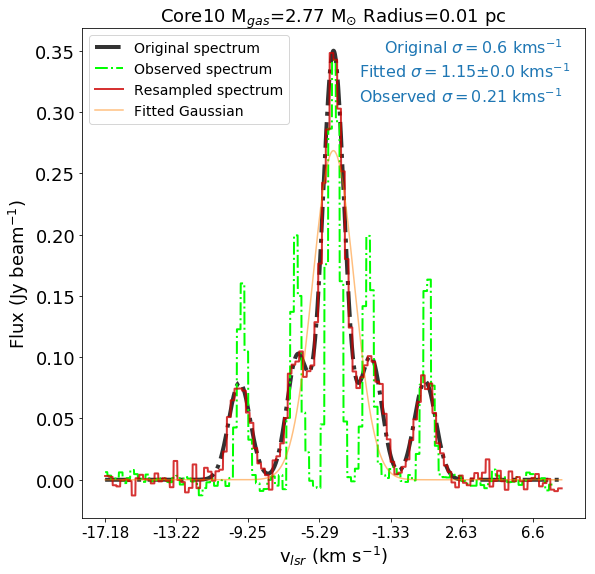

In [319]:


# define line strength file
lsfile = 'nh2d_linestrength.txt'




iterations = 1
linewidth_fits = np.zeros(iterations)

kk = [9]#[13]

#for i in range(2):
    #print 'i', i
for i in kk: 
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        #print itr
    # generate spectrum
        test_spectrum = gaussian_spectrum_split(
            name = 'test', 
            A = np.nanmax(spcube[i])/0.28432, 
            sigma = sigma[i]/v_pix, 
            bins = 1920)
        print peak_intensity[i],sigma[i]
       # print 'sigma[i]',sigma[i], 'sigma[i]/v_pix',sigma[i]/v_pix
        test_spectrum.loadstrength('nh2d_linestrength.txt')
        test_spectrum.getflux(pixelsize_Hz=v_pix_Hz)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    )    
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 1920 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=2, 
                     label = 'Observed spectrum'
                    ) 

    
    # inject noise
        noise = np.nanmax(spcube[i]) / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        #plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
            # linewidth=2, label = 'Noisy spectrum'
        #        )
           
    # resampling
        #test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        #print int(v_delta / v_pix)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
                     color = (0.8, 0.0, 0.0, 0.8),
                     linewidth = 2, 
                     label = 'Resampled spectrum'
                    )    
        else:
            pass  

    # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                     label='Fitted Gaussian'
                    )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                         color = (1, 0.5, 0, 0.5),
                        )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
                     'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                    )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                     %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
        
            plt.text( 0.55, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )

    plt.title('Core%s M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( i+1, str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0, 300, 600, 900, 1200, 1500, 1800), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+300*25.357/1920, 2))),
                '%s'%( str( round(fvpix+600*25.357/1920, 2))),
                '%s'%( str( round(fvpix+900*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1200*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1500*25.357/1920, 2))),
                '%s'%( str( round(fvpix+1800*25.357/1920, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)

    #plt.savefig('simulation_split_%s.pdf'%(str(i)), 
    #          transparent = True
    #            )

In [271]:


G       = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.213      # km/s
v_pix   = v_delta / 16.0  # general finner pixel grids for the original spectrum

# Assuming cores are virialized
alpha      = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))
Reff       = Dreff * (1300.0 / 206265.0)         # angular radius --> 
sigma      = np.sqrt(alpha * Mgas * G /(5.* Reff))  # km/s
#'''
peak_intensity = []
peak_sn        = []
spcube         = []
#for i in range(size(T)):
for i in range(5):
    Adata1         = np.where(data2 == i, data5, np.nan)
    Adata1_err     = np.where(data2 == i, data6, np.nan)
    peak_intensity = np.append(peak_intensity, np.nanmean(Adata1))
    peak_sn        = np.append(peak_sn, np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err))
    #print np.nanmean(Adata1)*1.0/np.nanmean(Adata1_err)
    #print i
    cube    = np.where( data2 == i, data3, np.nan )
    HDU     = fits.PrimaryHDU( data=cube, header=hdr3 )
    HDUList = fits.HDUList( [HDU] )
    cube    = SpectralCube.read( HDUList )
    cube.allow_huge_operations=True
    sp      = cube.mean( axis=(1,2) )
    spcube.append( sp.value )
## 29, 47  without sigma information
# 32, 33, 40, 41, 45, 46, 48, without beam-deconvolved radius

core_index = []
for i in range(size(T)):
    mapidex = np.where(data2 == i, data4, np.nan)
    if np.nanmax(mapidex) > 1:
        core_index.append(i)
#'''
print "Done ~ ^ ^ ~"

/home/sli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in divide
  # This is added back by InteractiveShellApp.init_path()


Done ~ ^ ^ ~


/home/sli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: All-NaN slice encountered


In [1]:
i = 0
#prin -17.6921+17.4791, 17.4791-17.2661
print len(spcube),  'Tpeak=%s'%(np.nanmax(spcube[i])), sigma[i]#/v_pix

print peak_intensity[i] , peak_sn[i]

print 1.769210002118E+04

print v_pix
v_pix_Hz = 8.593133089470E+10 * v_pix/(3e5)
print 'v_pix_Hz (Hz)=', v_pix_Hz

print 120*16
#print sigma
print 0.09296+ 0.00000+ 0.02677+0.02341+ 0.00798+ \
0.01984+0.17288+0.03609+ 0.01423+ 0.01265+ 0.00934+\
0.01131+0.06547+ 0.00541

NameError: name 'spcube' is not defined

0.07903307
sigma[i] 0.769249019398599 sigma[i]/v_pix 57.78396389848631


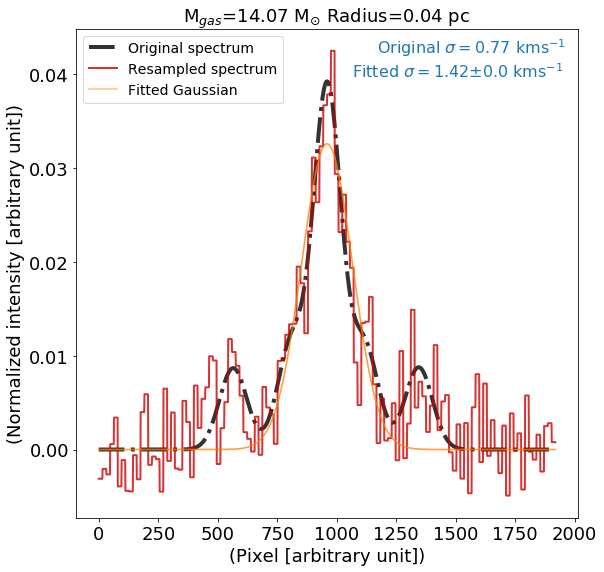

In [295]:
# define line strength file
lsfile = 'nh2d_linestrength.txt'



iterations = 1
linewidth_fits = np.zeros(iterations)


#for i in range(0, 2 ):
for i in range(1): 
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum_split(
            name = 'test', 
            A = np.nanmax(spcube[i]), 
            sigma = sigma[i]/v_pix, 
            bins = 1920)
        print np.nanmax(spcube[i])
        print 'sigma[i]',sigma[i], 'sigma[i]/v_pix',sigma[i]/v_pix
        test_spectrum.loadstrength('nh2d_linestrength.txt')
        test_spectrum.getflux(pixelsize_Hz=v_pix_Hz)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    )    
            
    # plotting the observed spctrum
            #sp_data, fvpix = resampleobs( spcube[i], 1920 )
            #plt.plot(sp_data, \
            #         '-.',
            #         color = 'lime',
            #         linewidth=4, 
            #         label = 'Observed spectrum'
            #        ) 

    
    # inject noise
        noise = np.nanmax(spcube[i]) / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        #plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
            # linewidth=2, label = 'Noisy spectrum'
        #        )
           
    # resampling
        #test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        #print int(v_delta / v_pix)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
                     color = (0.8, 0.0, 0.0, 0.8),
                     linewidth = 2, 
                     label = 'Resampled spectrum'
                    )    
        else:
            pass  

    # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                     label='Fitted Gaussian'
                    )
    else:
        if ( itr % 5 == 0):
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                    )
    linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

    if (itr == 0):
        plt.text( 0.6, 0.95,
           'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
           {'color': 'C0', 'fontsize': 16},
           transform=figure.transAxes
          )
    
    if (itr == (iterations-1) ):
        plt.text( 0.55, 0.9,
           'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
           %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
           {'color': 'C0', 'fontsize': 16},
           transform=figure.transAxes
          )


    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( '(Pixel [arbitrary unit])', size=18)
    plt.ylabel( '(Normalized intensity [arbitrary unit])', size=18)
    plt.legend(loc=2, fontsize=14)

    #plt.savefig('simulation_split_%s.pdf'%(str(i)), 
    #          transparent = True
    #            )

[10. 10. 10. 10. 10. 10. 10.] sigma/v_pix  [ 0.72676813  1.25879932  2.18030438  3.77639796  6.54091313 12.00818017
 20.79877816]


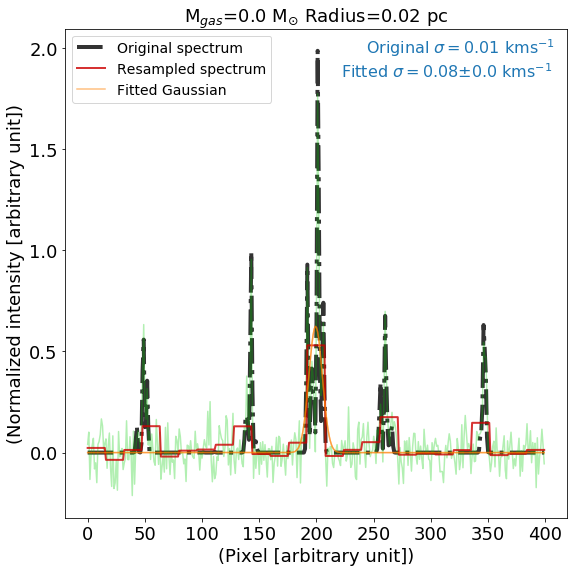

In [306]:
# define line strength file
lsfile = 'nh2d_linestrength.txt'

G       = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21      # km/s
v_pix   = v_delta / 16.0  # general finner pixel grids for the original spectrum


###### This part has to be replaced with data loading commands #####
Mgas = np.array(
                [0.01, 0.03, 0.09, 0.27, 0.81, 2.73, 8.19]
               ) * 0.1

# ** Is Dreff angular diameter or radius?
Dreff = np.array(
                [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
               )

peak_intensity = np.zeros( size(Mgas) ) + 10.0
peak_sn        = np.zeros( size(Mgas) ) + 15.0 * 36.0
#####################################################################



# Assuming cores are virialized
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))
Reff  = Dreff * (1300.0 / 206265.0)
sigma = np.sqrt(alpha * Mgas * G /(5.* Reff))

print peak_intensity,
print 'sigma/v_pix ',sigma/v_pix 

iterations = 1
linewidth_fits = np.zeros(iterations)


#for i in range(0, size(Mgas) ):
for i in [0]: 
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum_split(
            name = 'test', 
            A = peak_intensity[i], 
            sigma = sigma[i]/v_pix, 
            bins = 400)
        test_spectrum.loadstrength('nh2d_linestrength.txt')
        test_spectrum.getflux(pixelsize_Hz=10000.)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    )    

    
    # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        plt.plot(
                test_spectrum.x , test_spectrum.data,
                color = (0, 0.8, 0.0, 0.3),
            # linewidth=2, label = 'Noisy spectrum'
                )
           
    # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
                     color = (0.8, 0.0, 0.0, 0.8),
                     linewidth = 2, 
                     label = 'Resampled spectrum'
                    )    
        else:
            pass  

    # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                     label='Fitted Gaussian'
                    )
    else:
        if ( itr % 5 == 0):
            plt.plot(test_spectrum.x, spectrum_fit, 
                     color = (1, 0.5, 0, 0.5),
                    )
    linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

    if (itr == 0):
        plt.text( 0.6, 0.95,
           'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
           {'color': 'C0', 'fontsize': 16},
           transform=figure.transAxes
          )
    
    if (itr == (iterations-1) ):
        plt.text( 0.55, 0.9,
           'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
           %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
           {'color': 'C0', 'fontsize': 16},
           transform=figure.transAxes
          )


    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( '(Pixel [arbitrary unit])', size=18)
    plt.ylabel( '(Normalized intensity [arbitrary unit])', size=18)
    plt.legend(loc=2, fontsize=14)

    #plt.savefig('simulation_split_%s.pdf'%(str(i)), 
    #          transparent = True
    #            )

---

### Assuming the cores are virialized 

#### Plotting the spectral for all of dense cores that have H13CO+ detection.
---

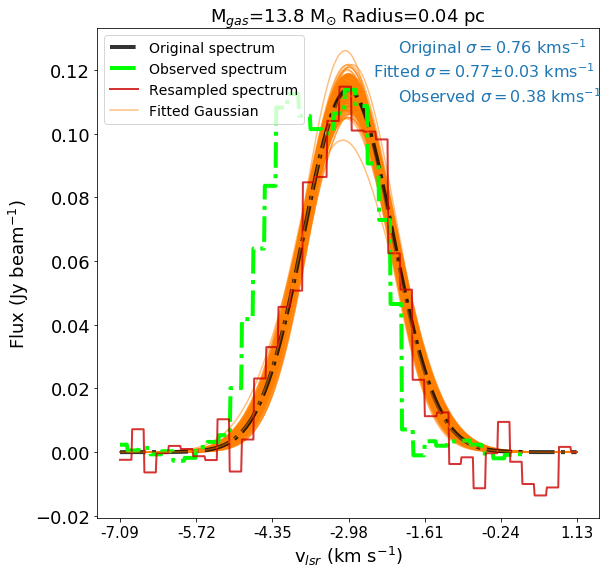

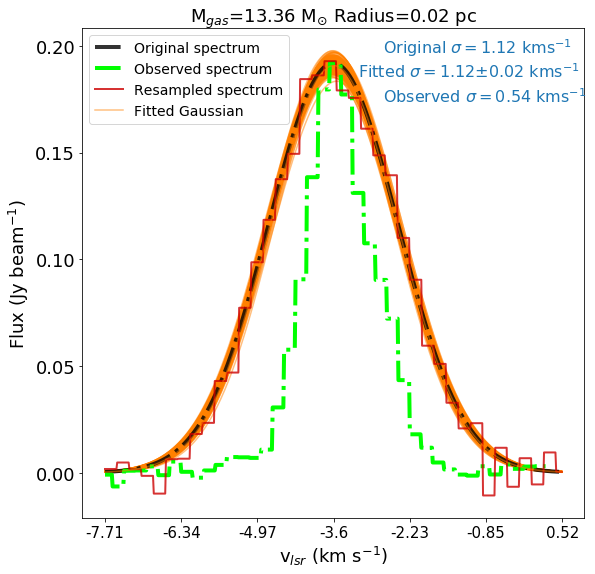

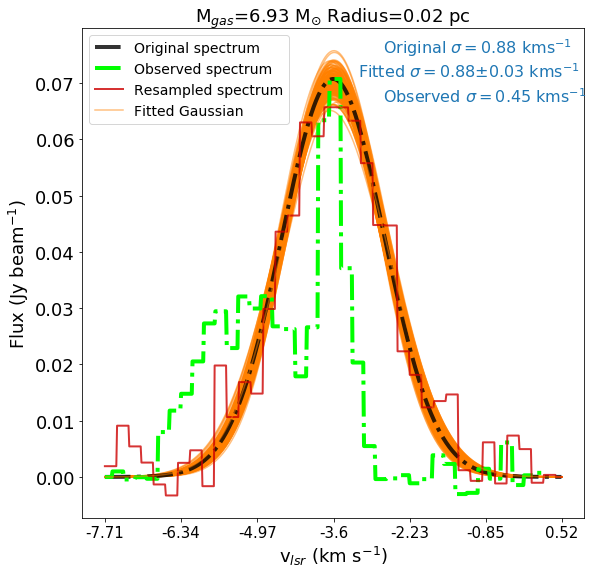

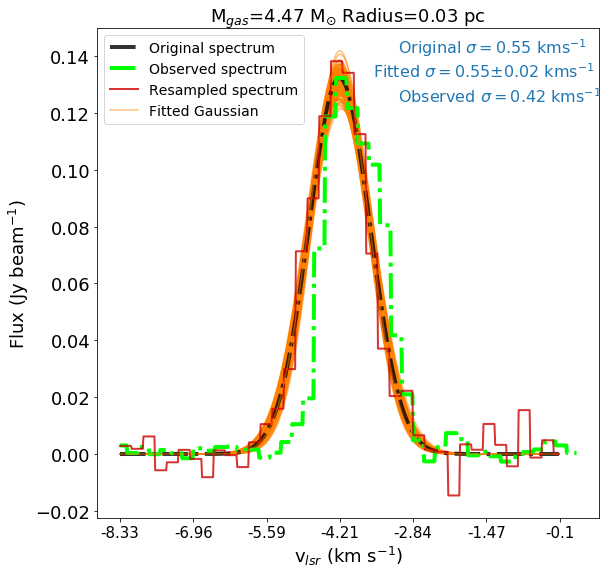

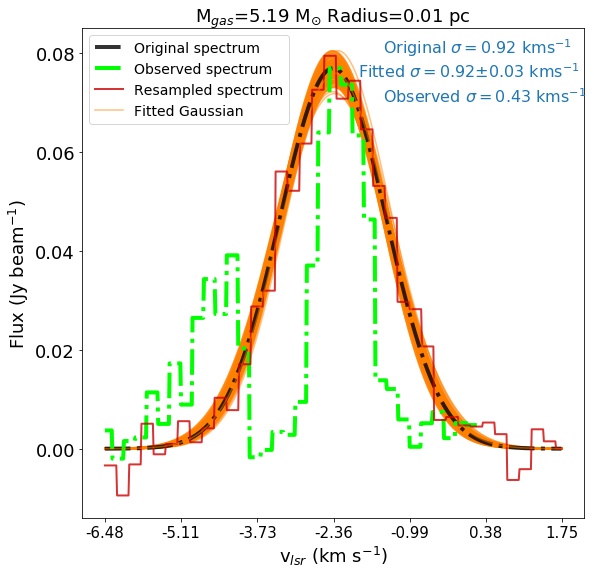

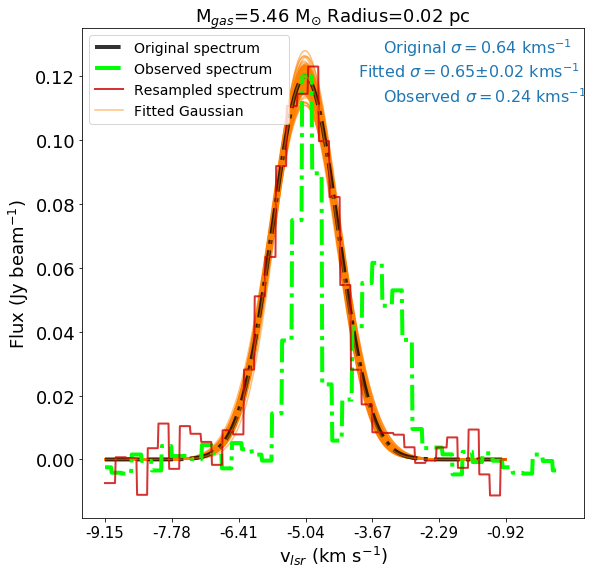

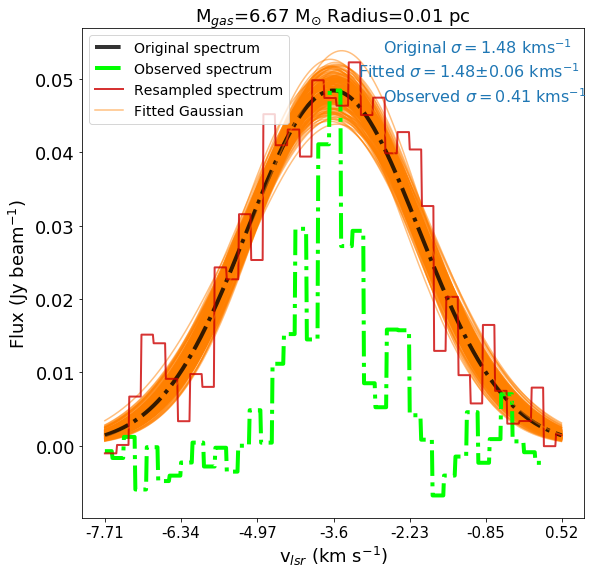

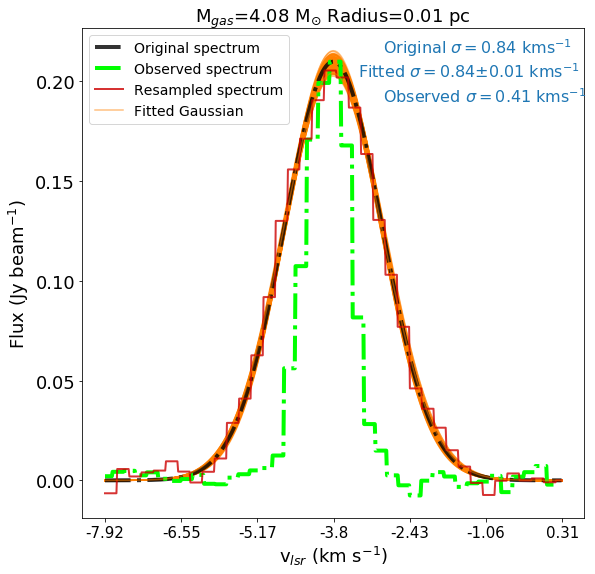

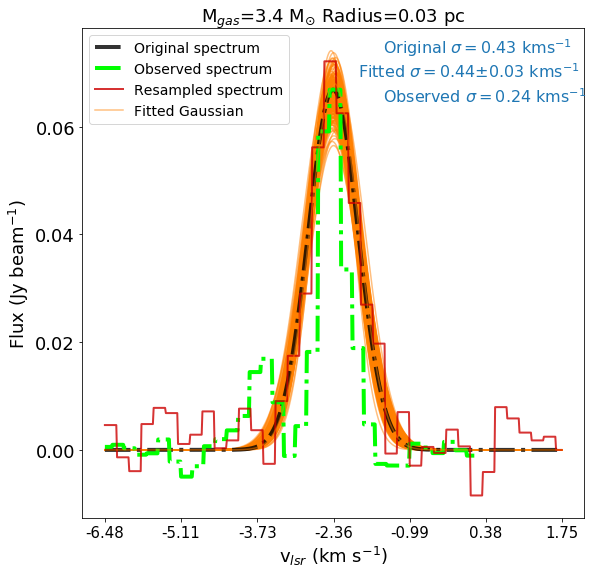

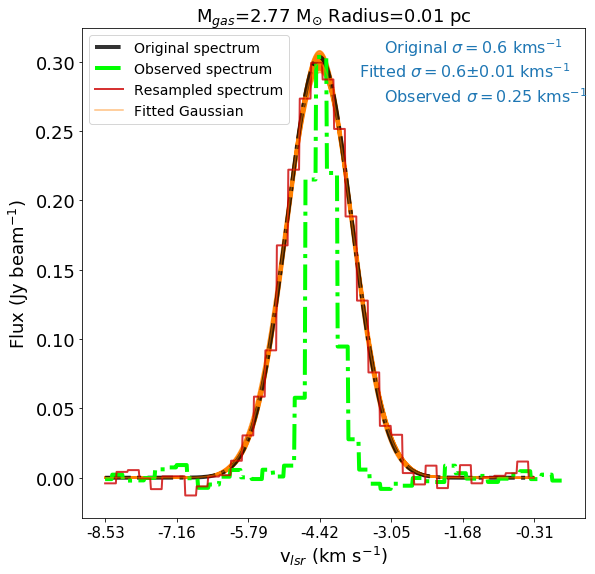

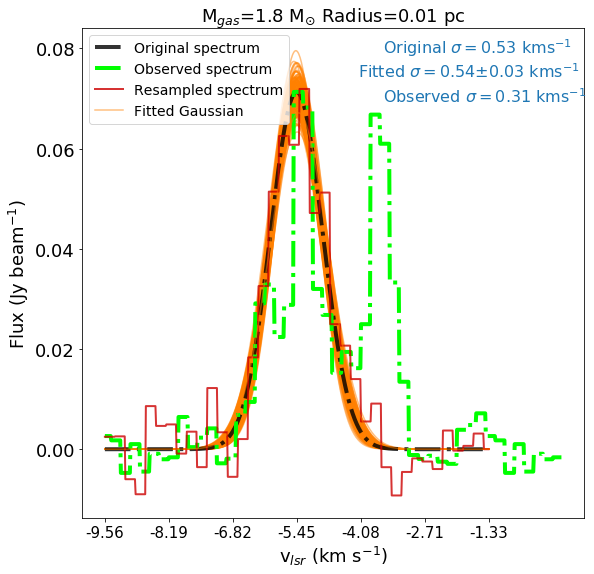

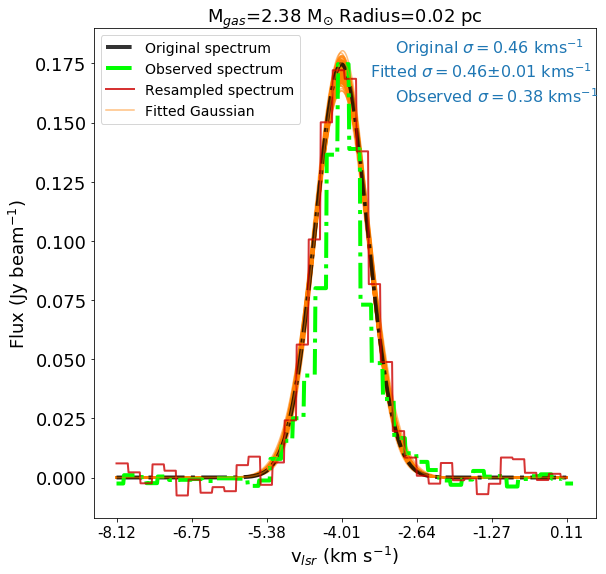

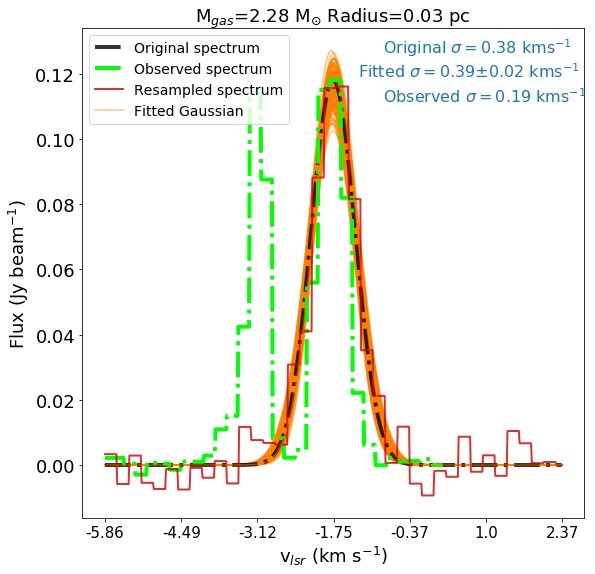

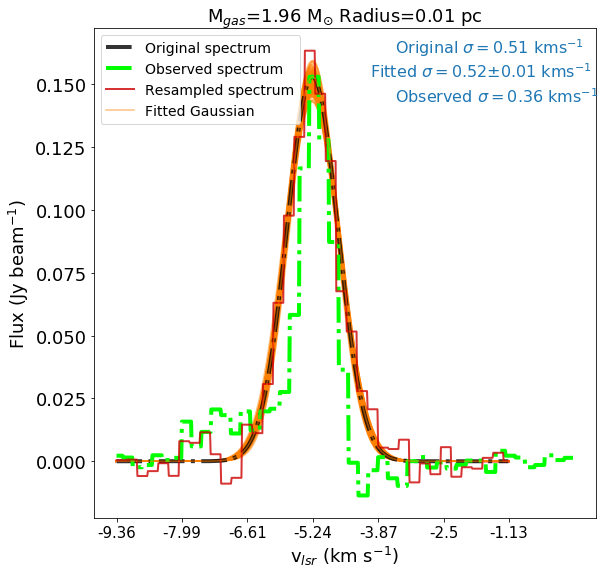

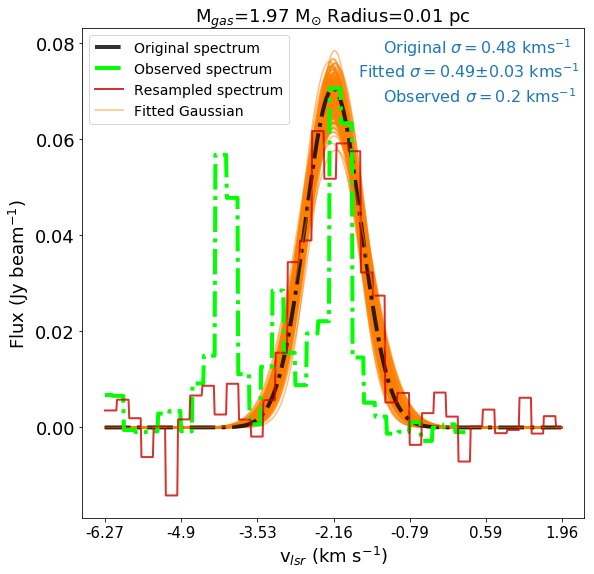

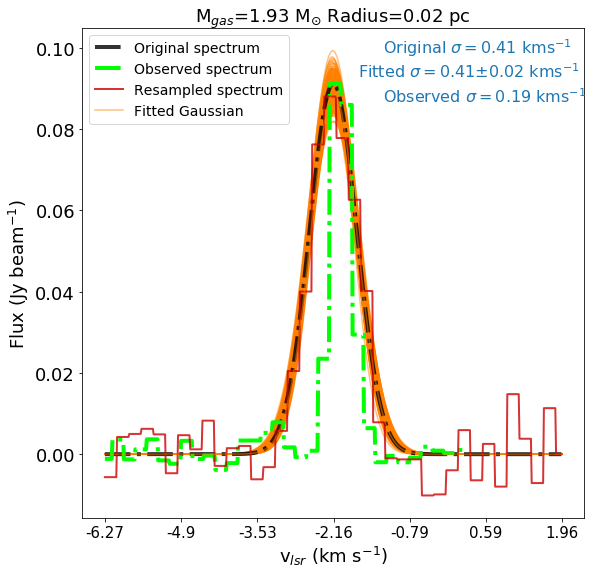

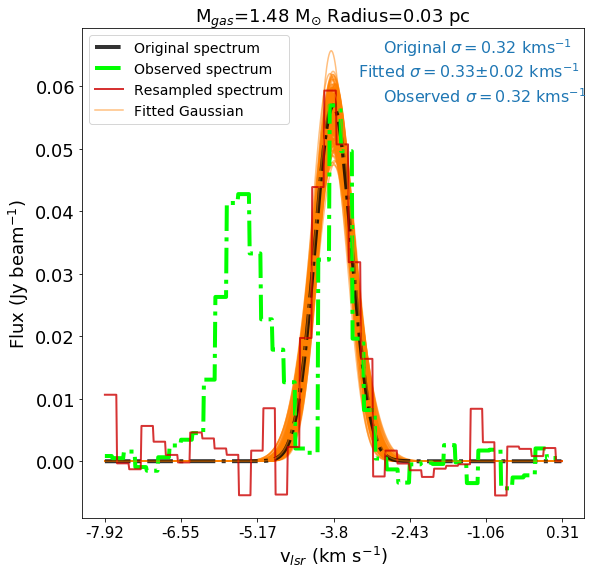

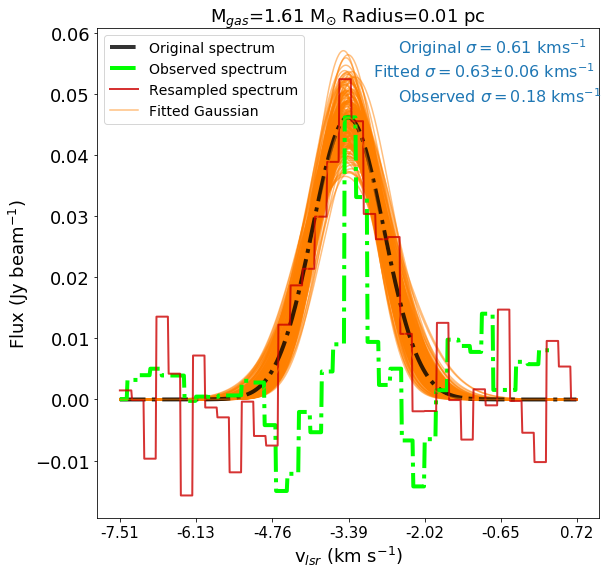

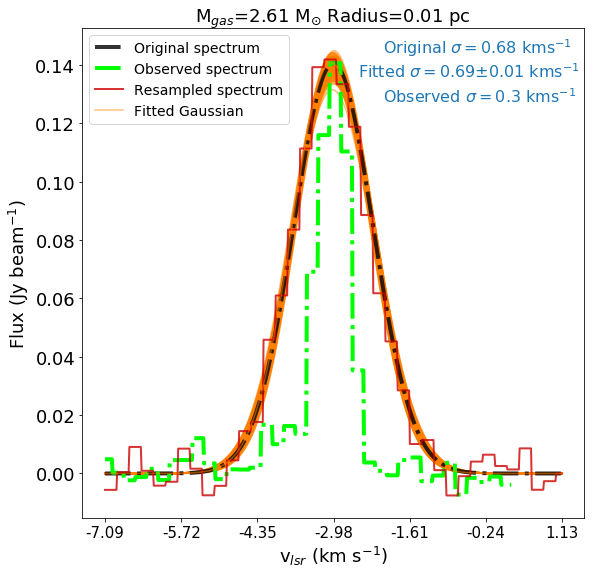

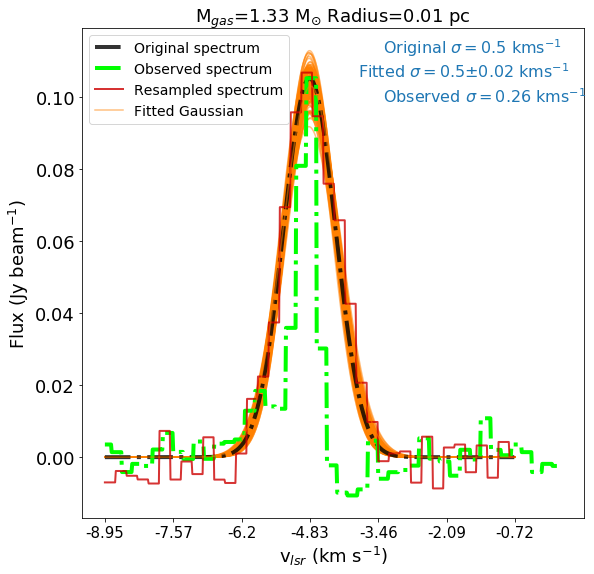

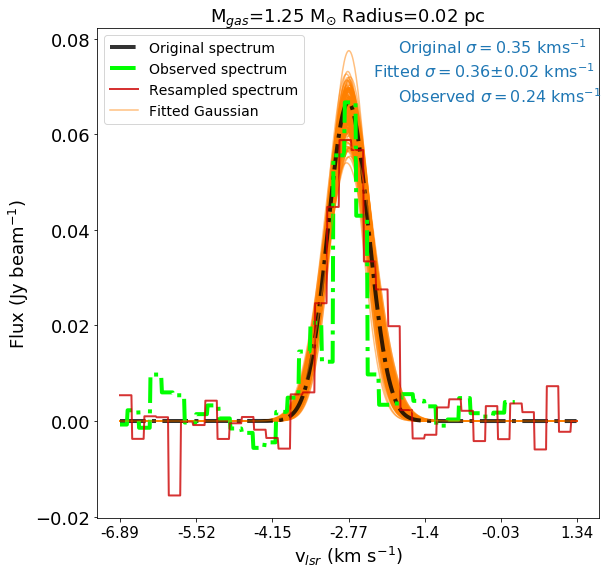

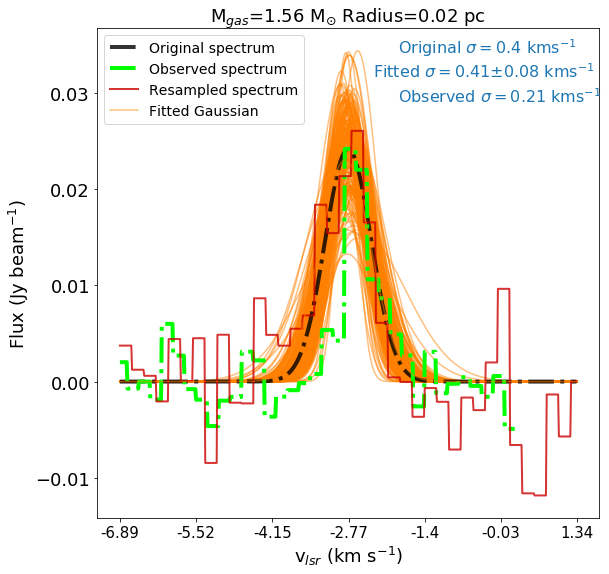

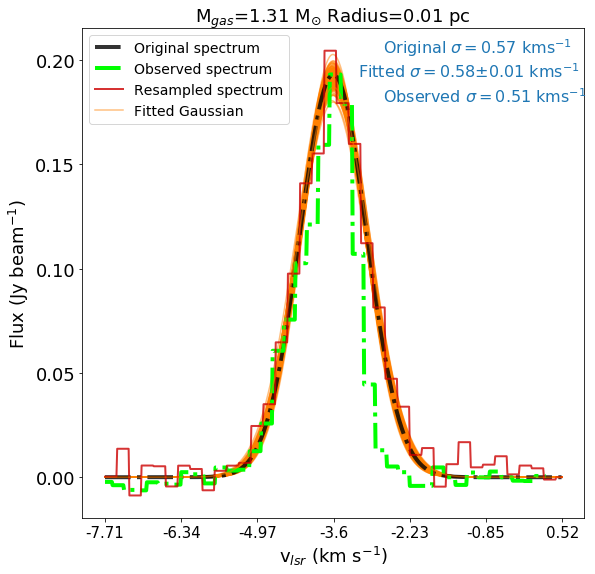

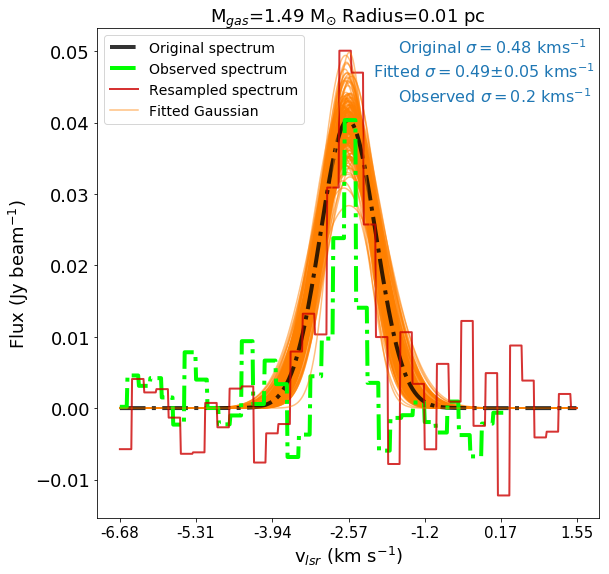

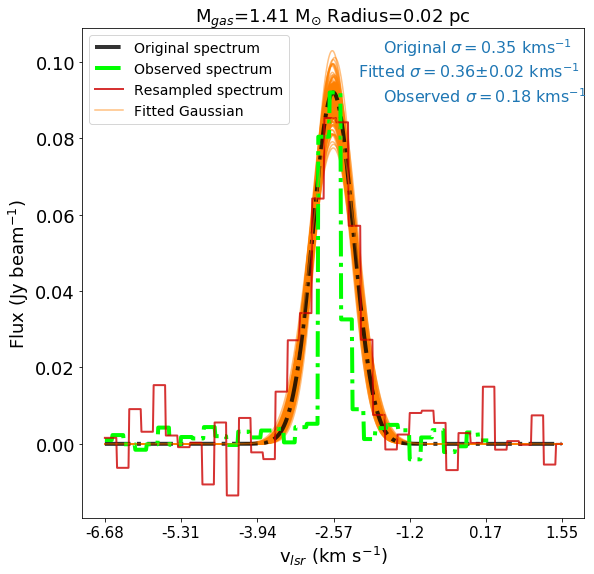

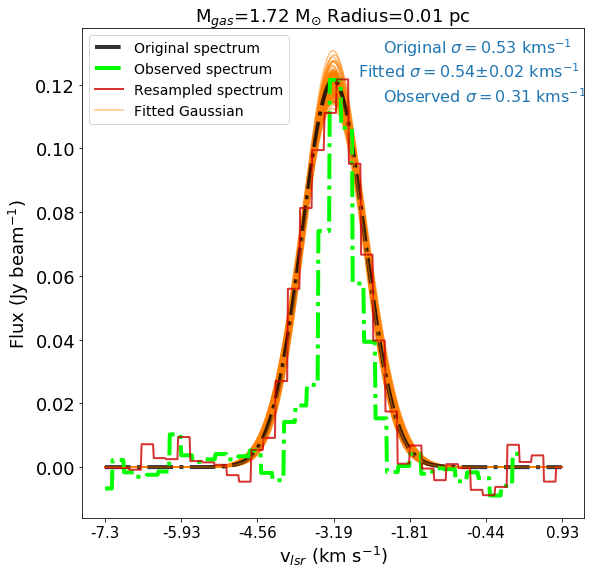

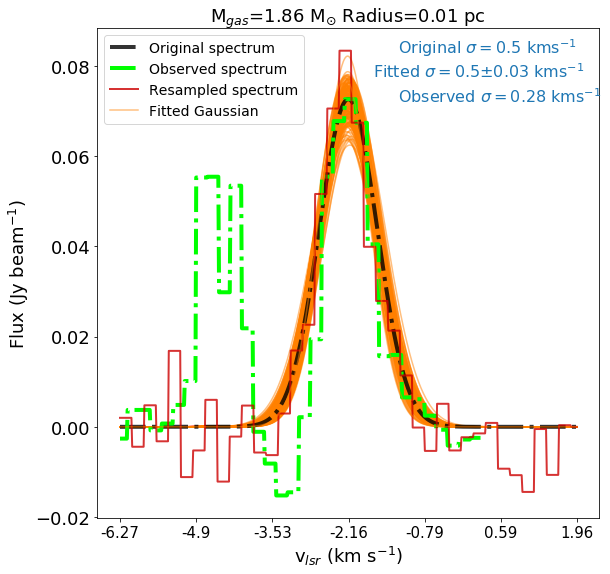

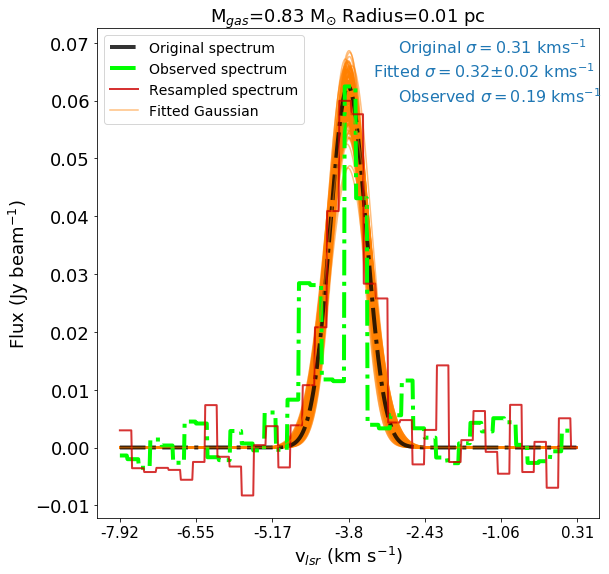

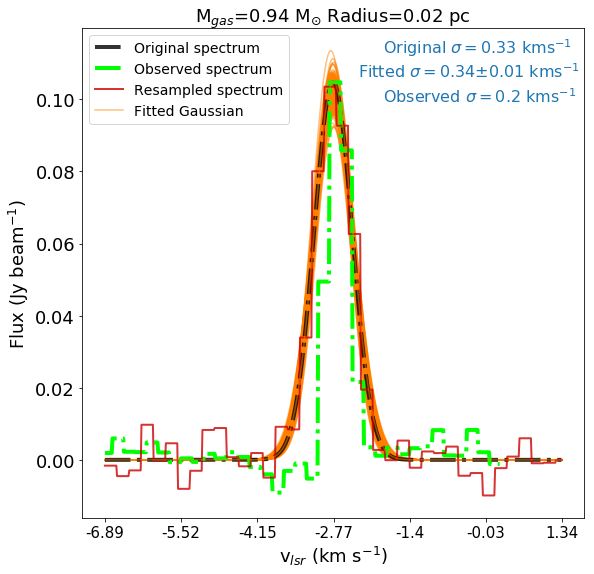

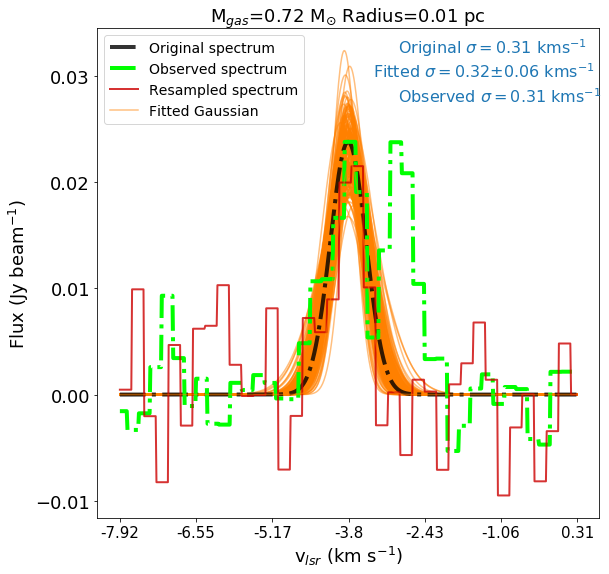

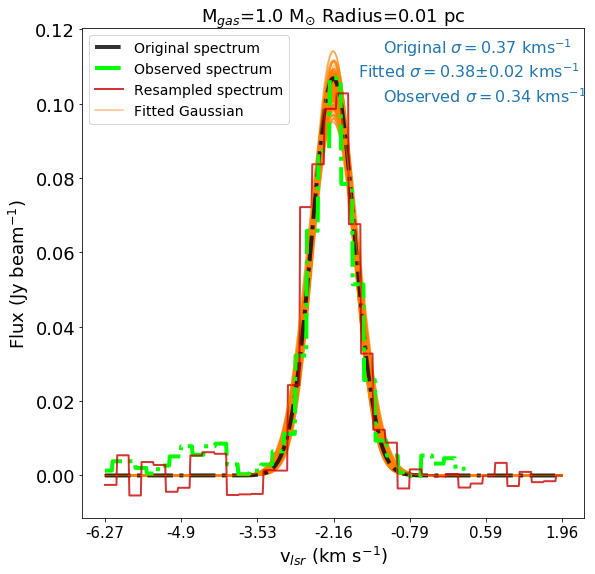

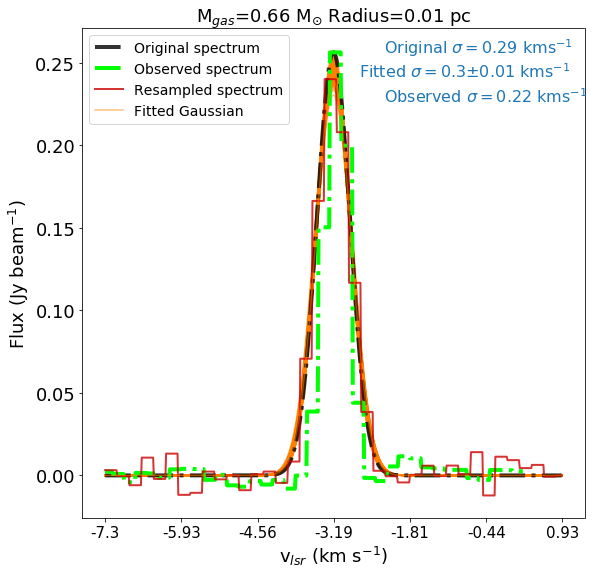

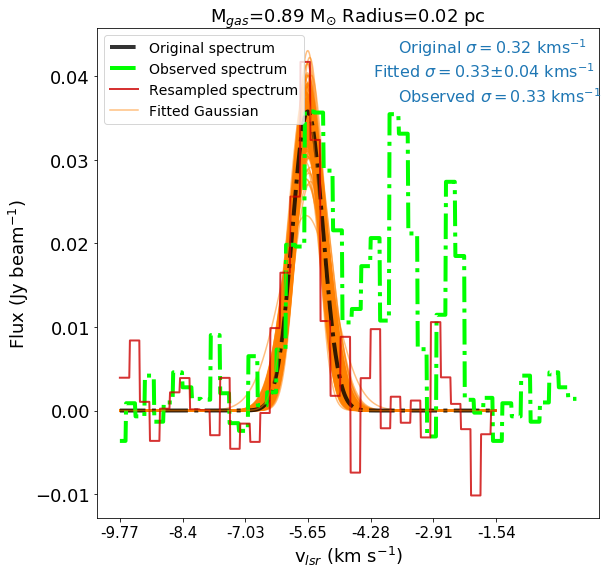

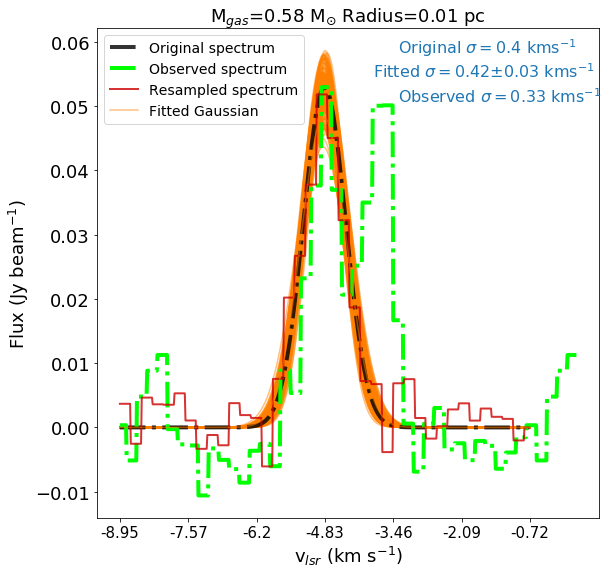

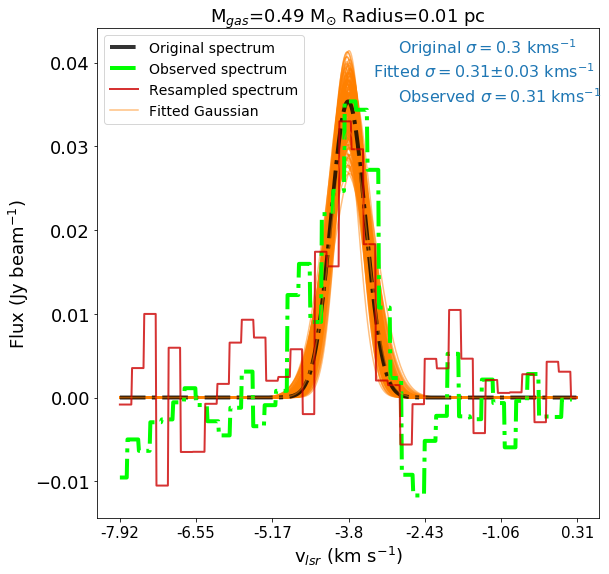

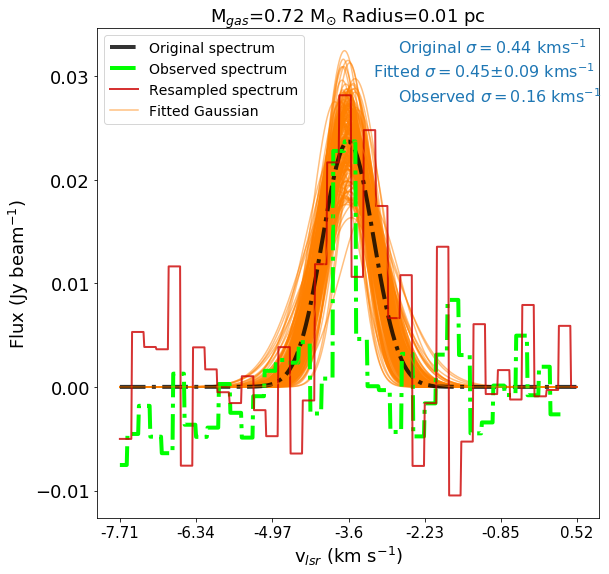

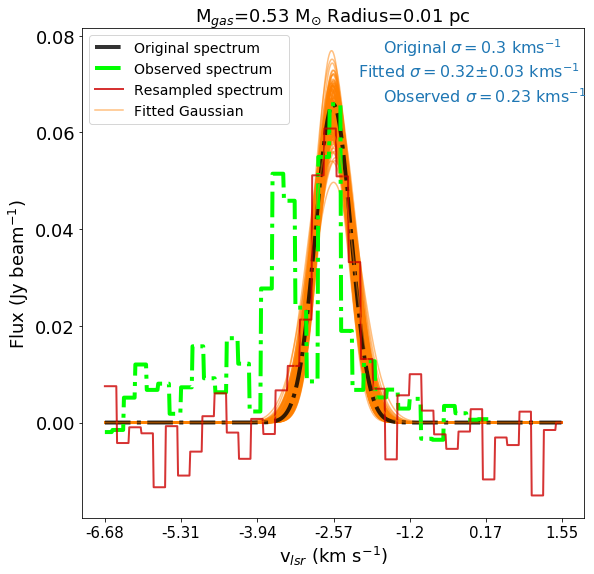

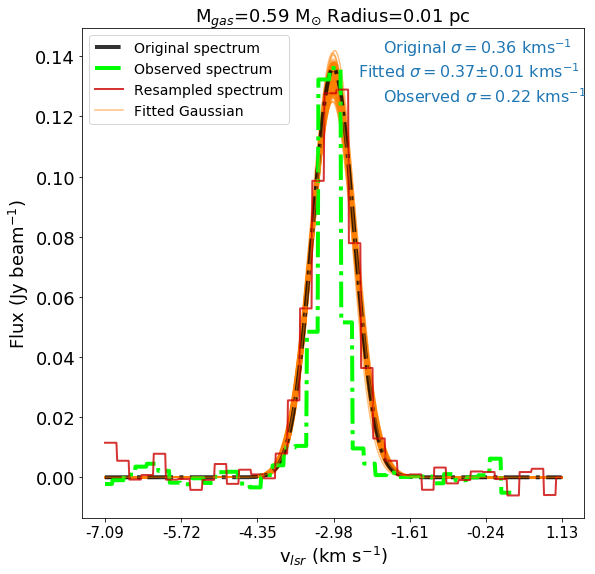

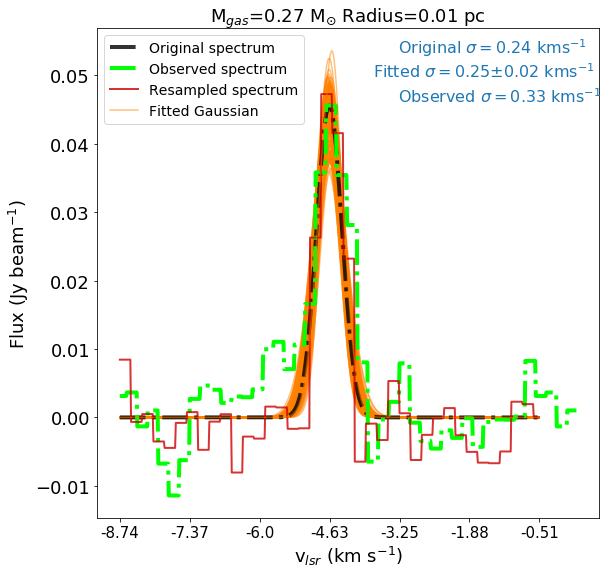

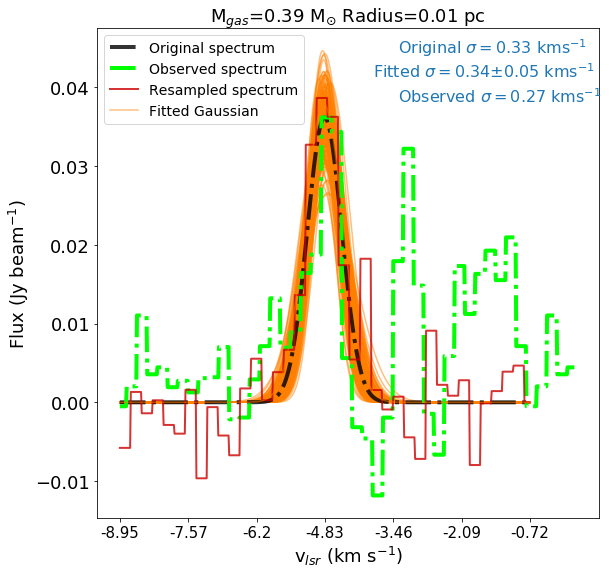

In [14]:

kk = range(0, size(Mgas) )


jj = [29,32,33,40,41,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk

#print kk

iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i],
                                    A = np.nanmax(spcube[i]),
                                    sigma = sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                    )
                     
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ), size=15)
    plt.legend(loc=2, fontsize=14)



---

### Assuming the cores are virialized 

#### Plotting the spectral for the dense cores that only detected single velocity component in H13CO+

---

21 321
-7.711985


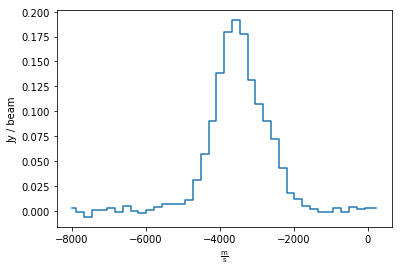

In [31]:

def resampleobs(sp, bins):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum

    #spdata = np.array( range( bins ) )
    #print spdata
    numbins = int( bins *1.0 / len(sp) )
    spdata = []
    j = 0
    i = 0
    for j in range( len(sp) ):
        for k in range(0, numbins):
            if i < bins:
                #print 'sp[j]={}'.format( sp[j] )
                spdata = np.append( spdata, sp[j] )
                #print 'i={}, k={}, j={}'.format( i, k, j )
                #print 'spdata[i] = {}'.format( spdata[i] )
                i += 1
    #print len(spdata)
    max_index = int( (np.max( ( np.where( spdata == np.nanmax(spdata) )[0] ) ) - \
                        len(np.where( spdata == np.nanmax(spdata) )[0])/2.0))
    
    delta_index = max_index - bins/2
    #print delta_index, max_index
    fvpix   = (8.229/600) * delta_index - 8  # the velocity of first pixel in km/s
    #print fvpix
    spdata1 = []
    j = delta_index - 1
    for i in range( (len(spdata) - delta_index) ):
        spdata1 = np.append( spdata1, spdata[j] )
        #print 'spdata[j] = {}'.format(spdata[j])
        j += 1
        #print j , i
    return spdata1, fvpix
    #print "Done ~ ^^ ~"
    
sp_data, fvpix = resampleobs( spcube[1], 600 )
#print len(sp_data), len(spcube[1])

cube    = np.where( data2 == 1, data3, np.nan )
HDU     = fits.PrimaryHDU( data=cube, header=hdr3 )
HDUList = fits.HDUList( [HDU] )
cube    = SpectralCube.read( HDUList )
sp      = cube.mean( axis=(1,2) )
sp.quicklook()
#print 8.229/600

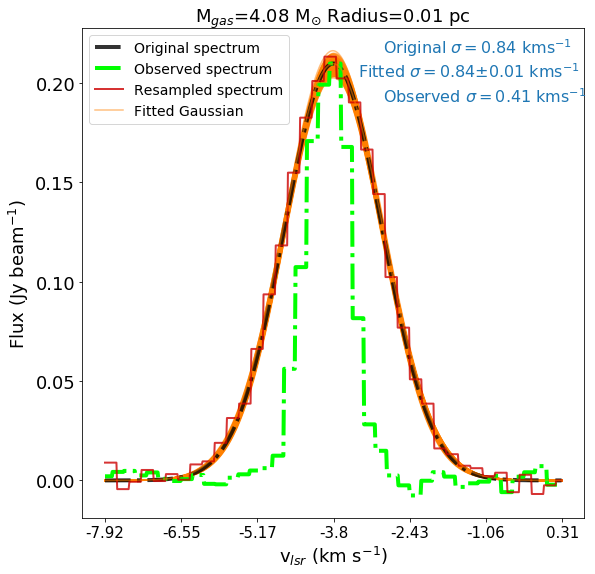

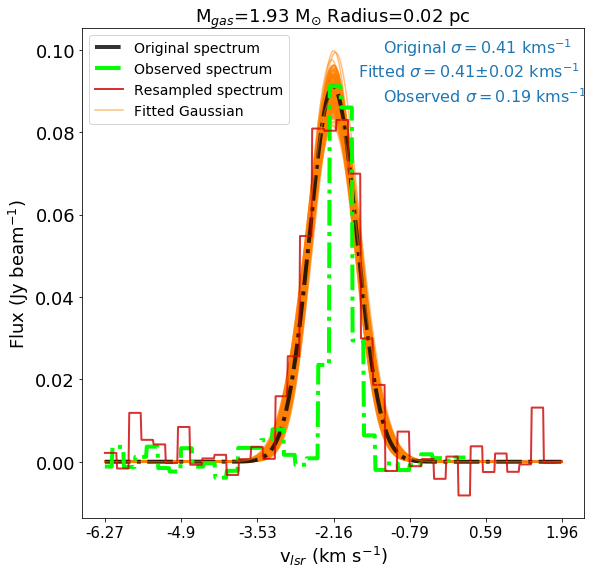

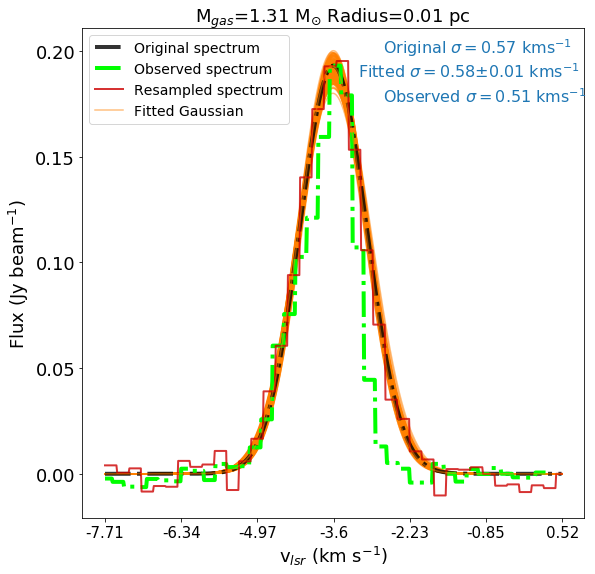

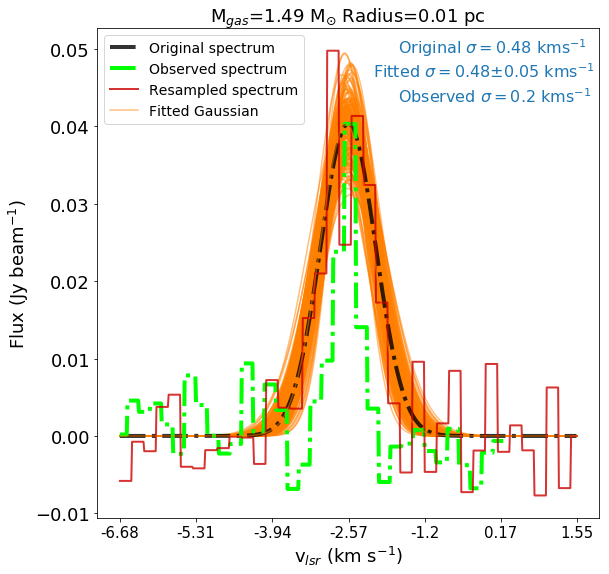

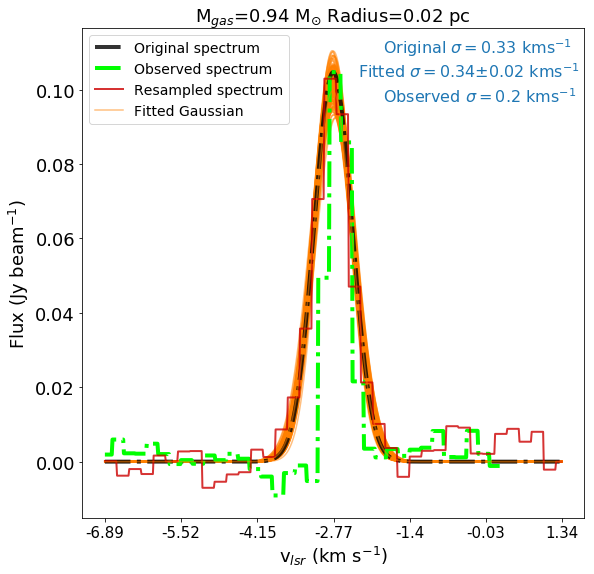

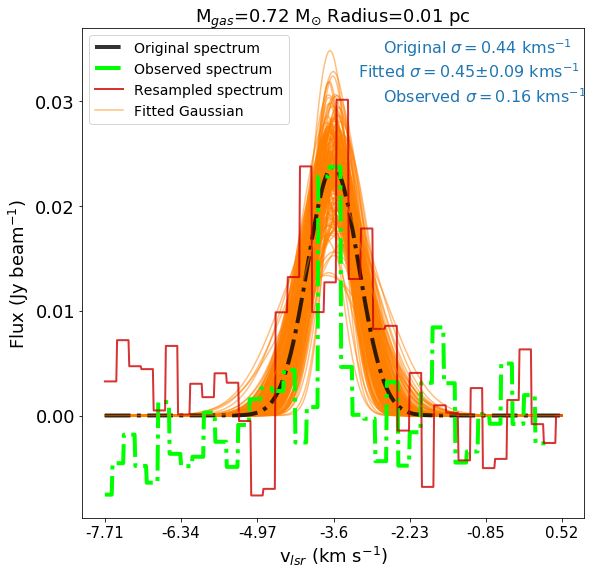

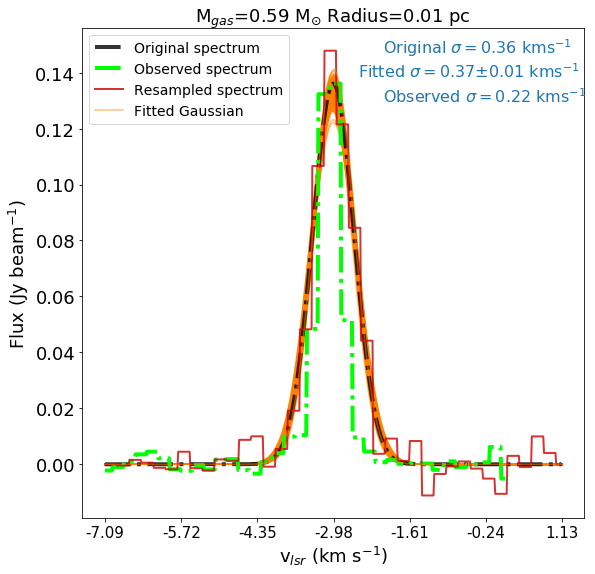

In [34]:
kk = range(0, size(Mgas) )

for i in core_index:
    temp = kk.index(i)
    #print temp
    kk.pop(temp)

#print kk

jj = [29,33,40,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk



iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i], 
                                    A = np.nanmax(spcube[i]),
                                    sigma = sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( sigma[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
            
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)




In [13]:
print 0.21/16


0.013125


---

### Generating the spectrum based on the observed paramters of H13CO+

#### The original A and sigma are from the measurement of H13CO+

---

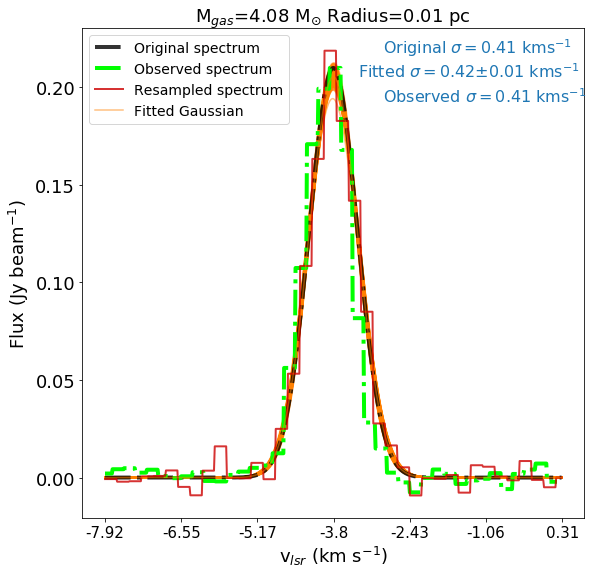

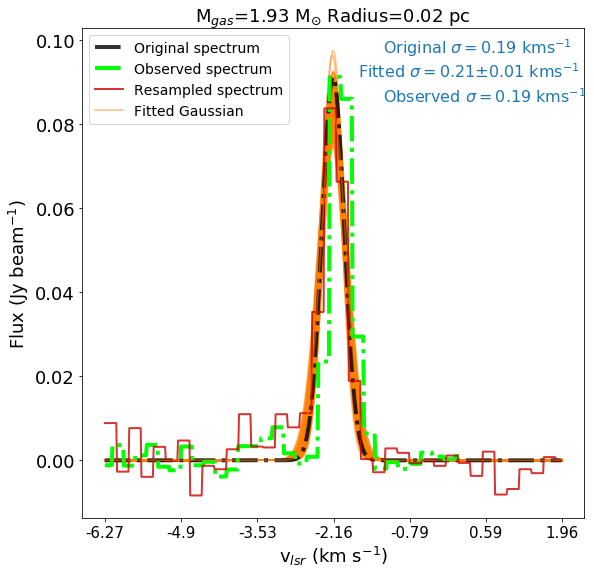

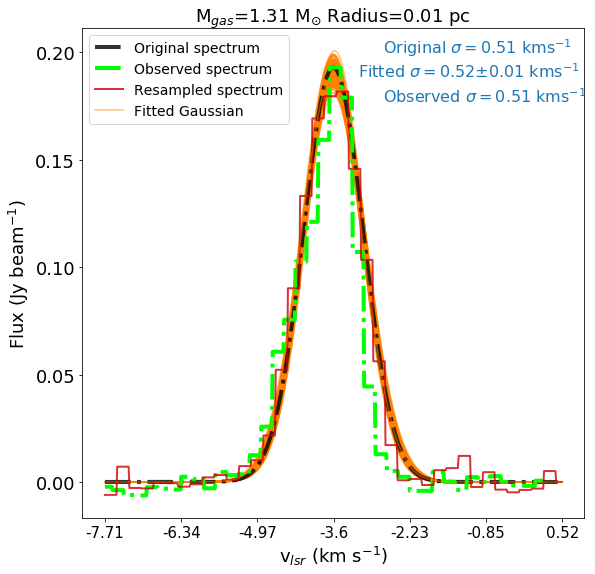

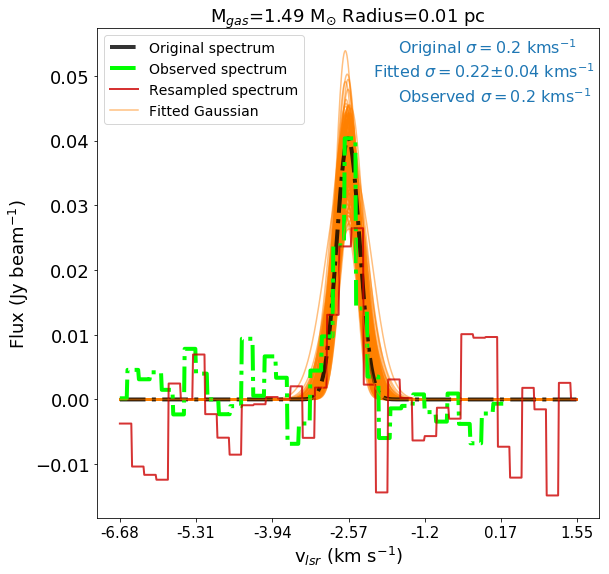

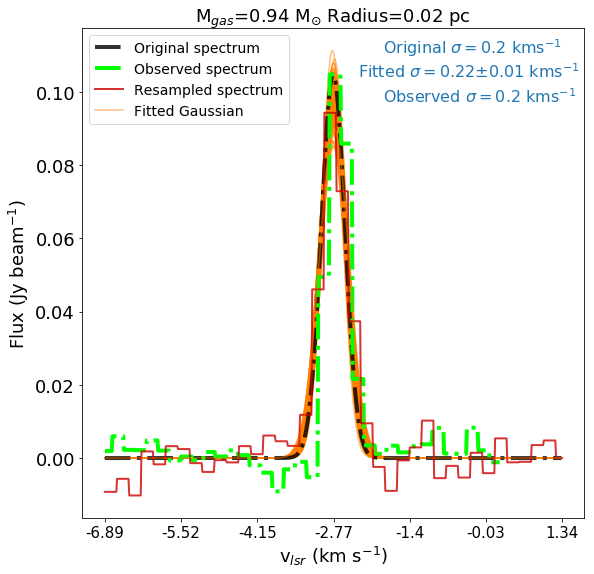

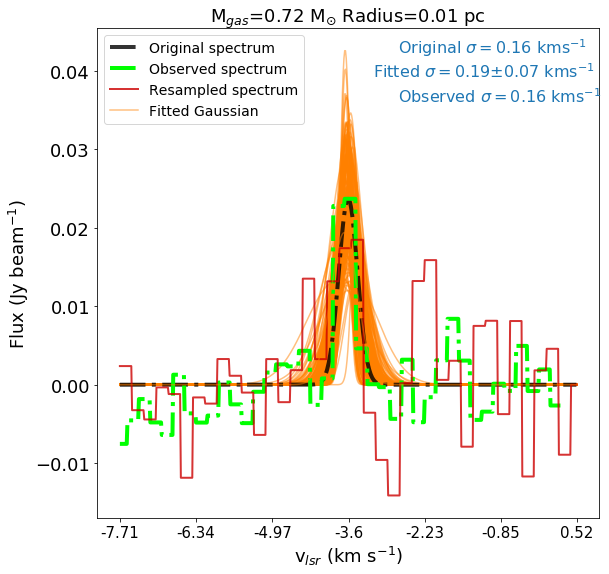

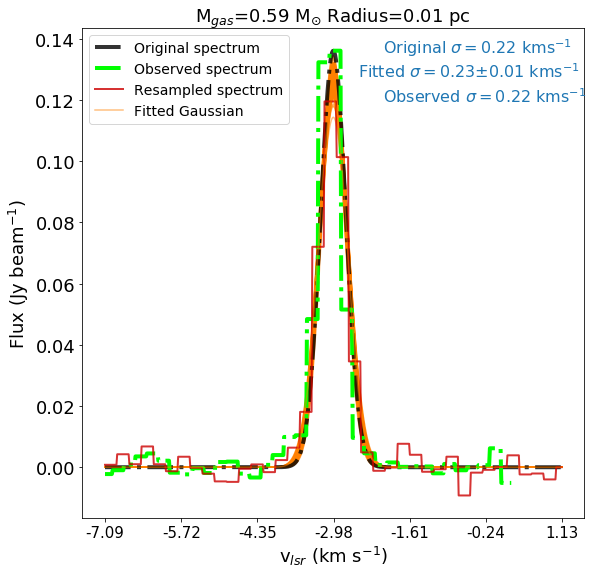

In [11]:
kk = range(0, size(Mgas) )

for i in core_index:
    temp = kk.index(i)
    #print temp
    kk.pop(temp)

#print kk

jj = [29,33,40,45,46,47,48]
for i in jj:
    temp = kk.index(i)
    kk.pop(temp)
#print kk



iterations = 1000
linewidth_fits = np.zeros(iterations)


for i in kk:
#for i in range( 0, 5 ):
  # Initialize figures
    fig = plt.figure(figsize=(9, 9))
    figure = plt.subplot(1, 1, 1)
    figure.tick_params(axis='both', which='major', labelsize=18)


    for itr in range(0, iterations):
        
    # generate spectrum
        test_spectrum = gaussian_spectrum(
                                    name = 'test', 
                                    #A = peak_intensity[i], 
                                    A = np.nanmax(spcube[i]),
                                    sigma = Asig[i]/v_pix, #sigma[i]/v_pix, 
                                    bins = 600)

    # plotting the original gaussian spectrum
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.data, \
                     '-.',
                     color = (0, 0, 0.0, 0.8),
                     linewidth=4, 
                     label = 'Original spectrum'
                    ) 
            
    # plotting the observed spctrum
            sp_data, fvpix = resampleobs( spcube[i], 600 )
            plt.plot(sp_data, \
                     '-.',
                     color = 'lime',
                     linewidth=4, 
                     label = 'Observed spectrum'
                    ) 

    
        # inject noise
        noise = peak_intensity[i] / peak_sn[i]
        noise = noise * np.sqrt( v_delta / v_pix )
        test_spectrum.add_noise( RMS = noise )
        # plt.plot(
        #        test_spectrum.x , test_spectrum.data,
        #        color = (0, 0.8, 0.0, 0.3),
        #        linewidth=2, label = 'Noisy spectrum'
        #        )
           
        # resampling
        test_spectrum.resample(pixelsize = int(v_delta / v_pix), pixelshift=0)
        if (itr == (iterations-1) ):
            plt.plot(test_spectrum.x , test_spectrum.resampleddata,
               color = (0.8, 0.0, 0.0, 0.8),
               linewidth = 2, 
               label = 'Resampled spectrum'
               )    
        else:
            pass  

        # fit Gaussian and print the results
        coeff = test_spectrum.refit_gaussian()
        spectrum_fit = gauss( test_spectrum.x, *coeff)
        if (itr == (iterations-1) ):    
            plt.plot(test_spectrum.x, spectrum_fit, 
               color = (1, 0.5, 0, 0.5),
               label='Fitted Gaussian'
               )
        else:
            if ( itr % 5 == 0):
                plt.plot(test_spectrum.x, spectrum_fit, 
                color = (1, 0.5, 0, 0.5),
                 )
        linewidth_fits[itr] = coeff[2] * v_delta * (v_pix/v_delta)

        if (itr == 0):
            plt.text( 0.6, 0.95,
               'Original $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i],2 ) )), 
               {'color': 'C0', 'fontsize': 16},
               transform=figure.transAxes
              )
    
        if (itr == (iterations-1) ):
            plt.text( 0.55, 0.9,
                     'Fitted $\sigma=$%s$\pm$%s kms$^{-1}$' 
                    %( str( round( np.mean(linewidth_fits), 2 ) ), str( round( np.std(linewidth_fits), 2 ) )), 
                    {'color': 'C0', 'fontsize': 16},
                    transform=figure.transAxes
                    )

            plt.text( 0.6, 0.85,
                     'Observed $\sigma=$%s kms$^{-1}$' %(str( round( Asig[i], 2 ) )), 
                     {'color': 'C0', 'fontsize': 16},
                     transform=figure.transAxes
                     )
            
    plt.title('M$_{gas}$=%s M$_{\odot}$ Radius=%s pc' 
             %( str( round( Mgas[i],2 ) ), str( round( Reff[i],2 ) )  ), 
             size=18
           )
    plt.xlabel( 'v$_{lsr}$ (km s$^{-1}$)', size=18)
    plt.ylabel( 'Flux (Jy beam$^{-1}$)', size=18)
    plt.xticks((0,100, 200, 300, 400, 500, 600), 
               ('%s'%( str( round(fvpix, 2))),
                '%s'%( str( round(fvpix+100*8.229/600, 2))),
                '%s'%( str( round(fvpix+200*8.229/600, 2))),
                '%s'%( str( round(fvpix+300*8.229/600, 2))),
                '%s'%( str( round(fvpix+400*8.229/600, 2))),
                '%s'%( str( round(fvpix+500*8.229/600, 2))),
                '%s'%( str( round(fvpix+600*8.229/600, 2))),
               ),size=15)
    plt.legend(loc=2, fontsize=14)





In [36]:
print 8.229/(0.21/16.0)
print 

626.971428571


In [100]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1300./206265 * 1.31961   # pc
M = 0.27323      # Msolar
alpha = 2
sigma2fwhm = 2*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

sigma 0.23773723285703255 km/s 
FWHM 0.5598284013819307 km/s 
Reff 0.00831693695004 pc


In [101]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1000./206265#1300./206265 * 1.31961   # pc
M = 0.1#0.27323      # Msolar
alpha = 2

sigma = np.sqrt(alpha * M * G /(5* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

sigma 0.18837683137795902 km/s 
FWHM 0.443593538548233 km/s 
Reff 0.00484813225705 pc
